# Overview of Context-Aware Load Forecasting

Load forecasting is the process of predicting future energy consumption based on historical data and various influencing factors. Accurate load forecasting empowers consumers to make informed decisions about their energy usage, potentially leading to cost savings and enhanced energy efficiency. This project aims to leverage advancements in machine learning and deep learning to develop effective load forecasting and contextual analysis methods. By employing state-of-the-art neural network models such as Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) networks, along with traditional methods like Random Forest Regressor, we aim to enhance the precision of load forecasting for individual appliances and aggregate power consumption.

The process involves data preprocessing, feature extraction and model training. We utilize time series analysis methods to decompose power consumption data into trend, seasonal and residual components, providing insights into the underlying patterns. By employing cross-validation techniques, we ensure the robustness of our models. Our approach includes both traditional statistical methods and modern machine learning and deep learning algorithms to compare their performance and select the best-performing model for load forecasting. The incorporation of contextual information significantly improves prediction accuracy, emphasizing the importance of temporal and seasonal factors in load forecasting. The insights gained from this study contribute to the broader field of energy analytics by advancing the development of intelligent energy management systems.

#### Importing Essential Libraries

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Attention, Bidirectional, Concatenate, Input
from keras.models import Model
from keras.layers import Conv1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import yaml
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Read Metadata

In [ ]:
def read_metadata(house):
    metadata_file = f'/content/drive/MyDrive/UK DALE dataset/ukdale/metadata/building{house}.yaml'
    with open(metadata_file, 'r') as f:
        metadata = yaml.safe_load(f)
    return metadata

In [ ]:
def read_label(house):
    label_file = f'/content/drive/MyDrive/UK DALE dataset/ukdale/house_{house}/labels.dat'
    label = {}
    with open(label_file) as f:
        for line in f:
            splitted_line = line.split(' ')
            label[int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label

metadata = {}
labels = {}
for i in range(1, 6):
    metadata[i] = read_metadata(i)
    labels[i] = read_label(i)

for i in range(1, 6):
    print(f'House {i}: ', labels[i], '\n')

House 1:  {1: 'aggregate_1', 2: 'boiler_2', 3: 'solar_thermal_pump_3', 4: 'laptop_4', 5: 'washing_machine_5', 6: 'dishwasher_6', 7: 'tv_7', 8: 'kitchen_lights_8', 9: 'htpc_9', 10: 'kettle_10', 11: 'toaster_11', 12: 'fridge_12', 13: 'microwave_13', 14: 'lcd_office_14', 15: 'hifi_office_15', 16: 'breadmaker_16', 17: 'amp_livingroom_17', 18: 'adsl_router_18', 19: 'livingroom_s_lamp_19', 20: 'soldering_iron_20', 21: 'gigE_&_USBhub_21', 22: 'hoover_22', 23: 'kitchen_dt_lamp_23', 24: 'bedroom_ds_lamp_24', 25: 'lighting_circuit_25', 26: 'livingroom_s_lamp2_26', 27: 'iPad_charger_27', 28: 'subwoofer_livingroom_28', 29: 'livingroom_lamp_tv_29', 30: 'DAB_radio_livingroom_30', 31: 'kitchen_lamp2_31', 32: 'kitchen_phone&stereo_32', 33: 'utilityrm_lamp_33', 34: 'samsung_charger_34', 35: 'bedroom_d_lamp_35', 36: 'coffee_machine_36', 37: 'kitchen_radio_37', 38: 'bedroom_chargers_38', 39: 'hair_dryer_39', 40: 'straighteners_40', 41: 'iron_41', 42: 'gas_oven_42', 43: 'data_logger_pc_43', 44: 'childs_ta

### Data Pre-processing - Reading, Downsampling and Merging Energy Consumption Data from UK DALE Dataset

In [ ]:
# Specify the date ranges for each house
date_ranges = {
    1: ('2016-04-26', '2017-04-26'),
    2: ('2013-02-17', '2013-10-10'),
    3: ('2013-02-27', '2013-04-08'),
    4: ('2013-03-09', '2013-10-01'),
    5: ('2014-06-29', '2014-11-13')
}

def read_and_downsample_data(house, interval='30T', chunksize=10**6):
    path = f'/content/drive/MyDrive/UK DALE dataset/ukdale/house_{house}/'
    files = glob.glob(path + 'channel_*.dat')

    start_date, end_date = date_ranges[house]
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)

    all_channels_data = []

    for file in files:
        channel_num = file.split('_')[-1].split('.')[0]
        if channel_num.isdigit():
            channel_num = int(channel_num)
            if channel_num in labels[house]:
                chunks = []
                for chunk in pd.read_table(file, sep=' ', names=['unix_time', labels[house][channel_num]],
                                           dtype={'unix_time': 'int64', labels[house][channel_num]: 'float64'},
                                           chunksize=chunksize):
                    chunk['timestamp'] = pd.to_datetime(chunk['unix_time'], unit='s')
                    chunk.set_index('timestamp', inplace=True)
                    chunk.drop('unix_time', axis=1, inplace=True)
                    chunk = chunk.loc[start_date:end_date]  # Select the time range
                    chunks.append(chunk)

                if chunks:
                    data = pd.concat(chunks)
                    all_channels_data.append(data)

    df = pd.concat(all_channels_data, axis=1)

    # Check initial number of NaNs
    print(f"House {house} initial NaNs:\n", df.isna().sum())

    # Ensure that the dataframe is aligned correctly in time
    first_timestamp = df.index.min()
    new_index = pd.date_range(start=first_timestamp, end=df.index.max(), freq=interval)
    df = df.reindex(new_index)

    # Interpolate missing values
    df.interpolate(method='linear', inplace=True)

    # Forward and backward fill remaining NaNs
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Check number of NaNs after interpolation and filling
    print(f"House {house} NaNs after interpolation and filling:\n", df.isna().sum())

    # Convert Watts to kWh (assuming each row represents a 30-minute interval)
    df = df / 2 / 1000

    return df

# Read and merge data for each house
df = {}
for i in range(1, 6):
    df[i] = read_and_downsample_data(i)

House 1 initial NaNs:
 kettle_10                  25797980
toaster_11                 25622438
fridge_12                  25624471
microwave_13               25634362
lcd_office_14              29268388
hifi_office_15             29265970
breadmaker_16              28249083
amp_livingroom_17          25557878
adsl_router_18             25879498
livingroom_s_lamp_19       25775746
aggregate_1                25165163
soldering_iron_20          30203268
gigE_&_USBhub_21           29268287
hoover_22                  30174547
kitchen_dt_lamp_23         30203268
bedroom_ds_lamp_24         25955471
lighting_circuit_25        25165163
livingroom_s_lamp2_26      25601911
iPad_charger_27            28648982
subwoofer_livingroom_28    25562680
livingroom_lamp_tv_29      25560842
DAB_radio_livingroom_30    30203268
boiler_2                   25332134
kitchen_lamp2_31           30203268
kitchen_phone&stereo_32    25577243
utilityrm_lamp_33          25615158
samsung_charger_34         26128192
bedro

In [ ]:
for i in range(1, 6):
    print(f'House {i} data has shape: ', df[i].shape)
    display(df[i].head(10))

House 1 data has shape:  (17521, 53)


kettle_10  toaster_11  fridge_12  microwave_13  \
2016-04-26 00:00:00     0.0005         0.0        0.0        0.0005   
2016-04-26 00:30:00     0.0005         0.0        0.0        0.0005   
2016-04-26 01:00:00     0.0005         0.0        0.0        0.0005   
2016-04-26 01:30:00     0.0005         0.0        0.0        0.0005   
2016-04-26 02:00:00     0.0005         0.0        0.0        0.0005   
2016-04-26 02:30:00     0.0005         0.0        0.0        0.0005   
2016-04-26 03:00:00     0.0005         0.0        0.0        0.0005   
2016-04-26 03:30:00     0.0005         0.0        0.0        0.0005   
2016-04-26 04:00:00     0.0005         0.0        0.0        0.0005   
2016-04-26 04:30:00     0.0005         0.0        0.0        0.0005   

                     lcd_office_14  hifi_office_15  breadmaker_16  \
2016-04-26 00:00:00            0.0          0.0045            0.0   
2016-04-26 00:30:00            0.0          0.0045            0.0   
2016-04-26 01:00:00            0.0          0.0045            0.0   
2016-04-26 01:30:00            0.0          0.0045            0.0   
2016-04-26 02:00:00            0.0          0.0045            0.0   
2016-04-26 02:30:00            0.0          0.0045            0.0   
2016-04-26 03:00:00            0.0          0.0045            0.0   
2016-04-26 03:30:00            0.0          0.0045            0.0   
2016-04-26 04:00:00            0.0          0.0045            0.0   
2016-04-26 04:30:00            0.0          0.0045            0.0   

                     amp_livingroom_17  adsl_router_18  livingroom_s_lamp_19  \
2016-04-26 00:00:00                0.0        0.005000                0.0005   
2016-04-26 00:30:00                0.0        0.005000                0.0005   
2016-04-26 01:00:00                0.0        0.005000                0.0005   
2016-04-26 01:30:00                0.0        0.005000                0.0005   
2016-04-26 02:00:00                0.0        0.005000                0.0005   
2016-04-26 02:30:00                0.0        0.005000                0.0005   
2016-04-26 03:00:00                0.0        0.005000                0.0005   
2016-04-26 03:30:00                0.0        0.005000                0.0005   
2016-04-26 04:00:00                0.0        0.005000                0.0005   
2016-04-26 04:30:00                0.0        0.004944                0.0005   

                     ...  laptop_4  office_lamp3_50  office_pc_51  \
2016-04-26 00:00:00  ...    0.0085              0.0         0.001   
2016-04-26 00:30:00  ...    0.0085              0.0         0.001   
2016-04-26 01:00:00  ...    0.0085              0.0         0.001   
2016-04-26 01:30:00  ...    0.0085              0.0         0.001   
2016-04-26 02:00:00  ...    0.0085              0.0         0.001   
2016-04-26 02:30:00  ...    0.0085              0.0         0.001   
2016-04-26 03:00:00  ...    0.0085              0.0         0.001   
2016-04-26 03:30:00  ...    0.0085              0.0         0.001   
2016-04-26 04:00:00  ...    0.0085              0.0         0.001   
2016-04-26 04:30:00  ...    0.0085              0.0         0.001   

                     office_fan_52  LED_printer_53  washing_machine_5  \
2016-04-26 00:00:00          0.019          0.0005                0.0   
2016-04-26 00:30:00          0.019          0.0005                0.0   
2016-04-26 01:00:00          0.019          0.0005                0.0   
2016-04-26 01:30:00          0.019          0.0005                0.0   
2016-04-26 02:00:00          0.019          0.0005                0.0   
2016-04-26 02:30:00          0.019          0.0005                0.0   
2016-04-26 03:00:00          0.019          0.0005                0.0   
2016-04-26 03:30:00          0.019          0.0005                0.0   
2016-04-26 04:00:00          0.019          0.0005                0.0   
2016-04-26 04:30:00          0.019          0.0005                0.0   

                     dishwasher_6 

House 2 data has shape:  (11249, 19)


running_machine_10  laptop2_11  washing_machine_12  \
2013-02-17 15:39:19              0.0005         0.0               0.002   
2013-02-17 16:09:19              0.0005         0.0               0.002   
2013-02-17 16:39:19              0.0005         0.0               0.002   
2013-02-17 17:09:19              0.0005         0.0               0.002   
2013-02-17 17:39:19              0.0005         0.0               0.002   
2013-02-17 18:09:19              0.0005         0.0               0.002   
2013-02-17 18:39:19              0.0005         0.0               0.002   
2013-02-17 19:09:19              0.0005         0.0               0.002   
2013-02-17 19:39:19              0.0005         0.0               0.002   
2013-02-17 20:09:19              0.0005         0.0               0.002   

                     dish_washer_13  fridge_14  microwave_15  toaster_16  \
2013-02-17 15:39:19          0.0005     0.0055           0.0         0.0   
2013-02-17 16:09:19          0.0005     0.0055           0.0         0.0   
2013-02-17 16:39:19          0.0005     0.0055           0.0         0.0   
2013-02-17 17:09:19          0.0005     0.0055           0.0         0.0   
2013-02-17 17:39:19          0.0005     0.0055           0.0         0.0   
2013-02-17 18:09:19          0.0005     0.0055           0.0         0.0   
2013-02-17 18:39:19          0.0005     0.0055           0.0         0.0   
2013-02-17 19:09:19          0.0005     0.0055           0.0         0.0   
2013-02-17 19:39:19          0.0005     0.0055           0.0         0.0   
2013-02-17 20:09:19          0.0005     0.0055           0.0         0.0   

                     playstation_17  cooker_19  modem_18  aggregate_1  \
2013-02-17 15:39:19          0.0005        0.0    0.0045       0.2995   
2013-02-17 16:09:19          0.0005        0.0    0.0045       0.2995   
2013-02-17 16:39:19          0.0005        0.0    0.0045       0.2995   
2013-02-17 17:09:19          0.0005        0.0    0.0045       0.2995   
2013-02-17 17:39:19          0.0005        0.0    0.0045       0.2995   
2013-02-17 18:09:19          0.0005        0.0    0.0045       0.2875   
2013-02-17 18:39:19          0.0005        0.0    0.0045       0.2755   
2013-02-17 19:09:19          0.0005        0.0    0.0045       0.2635   
2013-02-17 19:39:19          0.0005        0.0    0.0045       0.2515   
2013-02-17 20:09:19          0.0005        0.0    0.0045       0.2395   

                     laptop_2  monitor_3  speakers_4  server_5  router_6  \
2013-02-17 15:39:19  0.007000    0.03100     0.00150  0.010500   0.00900   
2013-02-17 16:09:19  0.008250    0.03075     0.00350  0.010750   0.00900   
2013-02-17 16:39:19  0.009500    0.03050     0.00550  0.011000   0.00900   
2013-02-17 17:09:19  0.008500    0.03045     0.00525  0.011000   0.00925   
2013-02-17 17:39:19  0.007500    0.03040     0.00500  0.011000   0.00950   
2013-02-17 18:09:19  0.009938    0.03035     0.00500  0.010875   0.00950   
2013-02-17 18:39:19  0.012375    0.03030     0.00500  0.010750   0.00950   
2013-02-17 19:09:19  0.014812    0.03025     0.00500  0.010625   0.00950   
2013-02-17 19:39:19  0.017250    0.03020     0.00500  0.010500   0.00950   
2013-02-17 20:09:19  0.019688    0.03015     0.00500  0.010375   0.00950   

                     server_hdd_7  kettle_8  rice_cooker_9  
2013-02-17 15:39:19        0.0055       0.0         0.0005  
2013-02-17 16:09:19        0.0055       0.0         0.0005  
2013-02-17 16:39:19        0.0055       0.0         0.0005  
2013-02-17 17:09:19        0.0055       0.0         0.0005  
2013-02-17 17:39:19        0.0055       0.0         0.0005  
2013-02-17 18:09:19        0.0055       0.0         0.0005  
2013-02-17 18:39:19        0.0055       0.0         0.0005  
2013-02-17 19:09:19        0.0055       0.0         0.0005  
2013-02-17 19:39:19        0.0055       0.0         0.0005  
2013-02-17 20:09:19        0.0055       0.0         0.0005

House 3 data has shape:  (1879, 5)


kettle_2  aggregate_1  electric_heater_3  projector_5  \
2013-02-27 20:35:14    0.0005      0.00250              0.001          0.0   
2013-02-27 21:05:14    0.0005      0.00250              0.001          0.0   
2013-02-27 21:35:14    0.0005      0.00250              0.001          0.0   
2013-02-27 22:05:14    0.0005      0.01155              0.001          0.0   
2013-02-27 22:35:14    0.0005      0.02060              0.001          0.0   
2013-02-27 23:05:14    0.0005      0.02965              0.001          0.0   
2013-02-27 23:35:14    0.0005      0.03870              0.001          0.0   
2013-02-28 00:05:14    0.0005      0.04775              0.001          0.0   
2013-02-28 00:35:14    0.0005      0.05680              0.001          0.0   
2013-02-28 01:05:14    0.0005      0.06585              0.001          0.0   

                     laptop_4  
2013-02-27 20:35:14     0.000  
2013-02-27 21:05:14     0.000  
2013-02-27 21:35:14     0.000  
2013-02-27 22:05:14     0.000  
2013-02-27 22:35:14     0.000  
2013-02-27 23:05:14     0.000  
2013-02-27 23:35:14     0.002  
2013-02-28 00:05:14     0.004  
2013-02-28 00:35:14     0.006  
2013-02-28 01:05:14     0.008

House 4 data has shape:  (9859, 6)


aggregate_1  tv_dvd_digibox_lamp_2  kettle_radio_3  \
2013-03-09 14:40:07       0.3185               0.015000             0.0   
2013-03-09 15:10:07       1.3625               0.015000             0.0   
2013-03-09 15:40:07       1.1339               0.013200             0.0   
2013-03-09 16:10:07       0.9053               0.011400             0.0   
2013-03-09 16:40:07       0.6767               0.009600             0.0   
2013-03-09 17:10:07       0.4481               0.007800             0.0   
2013-03-09 17:40:07       0.2195               0.006000             0.0   
2013-03-09 18:10:07       0.2310               0.011562             0.0   
2013-03-09 18:40:07       0.2425               0.017125             0.0   
2013-03-09 19:10:07       0.2540               0.022687             0.0   

                     freezer_5  gas_boiler_4  \
2013-03-09 14:40:07   0.000000       0.00400   
2013-03-09 15:10:07   0.000000       0.00400   
2013-03-09 15:40:07   0.000000       0.00400   
2013-03-09 16:10:07   0.000000       0.00400   
2013-03-09 16:40:07   0.000000       0.00400   
2013-03-09 17:10:07   0.000000       0.00400   
2013-03-09 17:40:07   0.000000       0.00400   
2013-03-09 18:10:07   0.004227       0.01025   
2013-03-09 18:40:07   0.008455       0.01650   
2013-03-09 19:10:07   0.012682       0.02275   

                     washing_machine_microwave_breadmaker_6  
2013-03-09 14:40:07                                0.000000  
2013-03-09 15:10:07                                0.000000  
2013-03-09 15:40:07                                0.000000  
2013-03-09 16:10:07                                0.000000  
2013-03-09 16:40:07                                0.000000  
2013-03-09 17:10:07                                0.000000  
2013-03-09 17:40:07                                0.000000  
2013-03-09 18:10:07                                0.001063  
2013-03-09 18:40:07                                0.002125  
2013-03-09 19:10:07                                0.003187

House 5 data has shape:  (6544, 25)


steam_iron_12  24_inch_lcd_10  PS4_11  \
2014-06-29 16:23:48            0.0             0.0     0.0   
2014-06-29 16:53:48            0.0             0.0     0.0   
2014-06-29 17:23:48            0.0             0.0     0.0   
2014-06-29 17:53:48            0.0             0.0     0.0   
2014-06-29 18:23:48            0.0             0.0     0.0   
2014-06-29 18:53:48            0.0             0.0     0.0   
2014-06-29 19:23:48            0.0             0.0     0.0   
2014-06-29 19:53:48            0.0             0.0     0.0   
2014-06-29 20:23:48            0.0             0.0     0.0   
2014-06-29 20:53:48            0.0             0.0     0.0   

                     nespresso_pixie_13  atom_pc_14  toaster_15  kettle_18  \
2014-06-29 16:23:48                 0.0       0.011         0.0      0.001   
2014-06-29 16:53:48                 0.0       0.011         0.0      0.001   
2014-06-29 17:23:48                 0.0       0.011         0.0      0.001   
2014-06-29 17:53:48                 0.0       0.011         0.0      0.001   
2014-06-29 18:23:48                 0.0       0.011         0.0      0.001   
2014-06-29 18:53:48                 0.0       0.011         0.0      0.001   
2014-06-29 19:23:48                 0.0       0.011         0.0      0.001   
2014-06-29 19:53:48                 0.0       0.011         0.0      0.001   
2014-06-29 20:23:48                 0.0       0.011         0.0      0.001   
2014-06-29 20:53:48                 0.0       0.011         0.0      0.001   

                     home_theatre_amp_16  sky_hd_box_17  fridge_freezer_19  \
2014-06-29 16:23:48               0.0125         0.0095             0.0535   
2014-06-29 16:53:48               0.0125         0.0095             0.0535   
2014-06-29 17:23:48               0.0125         0.0095             0.0535   
2014-06-29 17:53:48               0.0125         0.0095             0.0535   
2014-06-29 18:23:48               0.0125         0.0095             0.0535   
2014-06-29 18:53:48               0.0125         0.0095             0.0535   
2014-06-29 19:23:48               0.0125         0.0095             0.0535   
2014-06-29 19:53:48               0.0125         0.0095             0.0535   
2014-06-29 20:23:48               0.0125         0.0095             0.0535   
2014-06-29 20:53:48               0.0125         0.0095             0.0535   

                     ...  stereo_speakers_bedroom_2  washer_dryer_24  \
2014-06-29 16:23:48  ...                     0.0005         0.008000   
2014-06-29 16:53:48  ...                     0.0005         0.008000   
2014-06-29 17:23:48  ...                     0.0005         0.008000   
2014-06-29 17:53:48  ...                     0.0005         0.007875   
2014-06-29 18:23:48  ...                     0.0005         0.007750   
2014-06-29 18:53:48  ...                     0.0005         0.007625   
2014-06-29 19:23:48  ...                     0.0005         0.007500   
2014-06-29 19:53:48  ...                     0.0005         0.007375   
2014-06-29 20:23:48  ...                     0.0005         0.007250   
2014-06-29 20:53:48  ...                     0.0005         0.007125   

                     vacuum_cleaner_25  i7_desktop_3  hairdryer_4  \
2014-06-29 16:23:48                0.0         0.056       0.0005   
2014-06-29 16:53:48                0.0         0.056       0.0005   
2014-06-29 17:23:48                0.0         0.056       0.0005   
2014-06-29 17:53:48                0.0         0.056       0.0005   
2014-06-29 18:23:48                0.0         0.056       0.0005   
2014-06-29 18:53:48                0.0         0.056       0.0005   
2014-06-29 19:23:48                0.0         0.056       0.0005   
2014-06-29 19:53:48                0.0         0.056       0.0005   
2014-06-29 20:23:48                0.0         0.056       0.0005   
2014-06-29 20:53:48                0.0         0.056       0.0005   

                     primary_tv_5  24_inch_lcd_bedroom_6  treadmill

In [ ]:
# Define the key appliances for each house (customize as needed)
key_appliances_per_house = {
    1: ['aggregate_1', 'washing_machine_5', 'dishwasher_6', 'tv_7', 'kettle_10', 'fridge_12', 'microwave_13'],
    2: ['aggregate_1', 'washing_machine_12', 'monitor_3', 'fridge_14', 'microwave_15', 'kettle_8'],
    3: ['aggregate_1', 'electric_heater_3', 'laptop_4', 'projector_5', 'kettle_2'],
    4: ['aggregate_1', 'tv_dvd_digibox_lamp_2', 'kettle_radio_3', 'freezer_5', 'gas_boiler_4'],
    5: ['aggregate_1', 'washing_machine_24', 'dishwasher_22', 'fridge_freezer_19', 'microwave_23', 'kettle_18', 'tv_5']
}

### Exploratory Data Analysis (EDA)

Summary Statistics

In [ ]:
print(f'Summary statistics for House 2:')
display(df[2].describe())

Summary statistics for House 2:


running_machine_10    laptop2_11  washing_machine_12  dish_washer_13  \
count        11249.000000  11249.000000        11249.000000    11249.000000   
mean             0.001408      0.001246            0.005393        0.010253   
std              0.008761      0.003379            0.014676        0.083530   
min              0.000500      0.000000            0.000500        0.000000   
25%              0.000500      0.000000            0.001550        0.000500   
50%              0.000500      0.000000            0.002000        0.000500   
75%              0.000500      0.000000            0.002000        0.000500   
max              0.323000      0.028000            0.164500        1.027500   

          fridge_14  microwave_15    toaster_16  playstation_17     cooker_19  \
count  11249.000000  11249.000000  11249.000000    11249.000000  11249.000000   
mean       0.017038      0.002757      0.000074        0.000482      0.000079   
std        0.016347      0.034725      0.000149        0.000080      0.000506   
min        0.005000      0.000000      0.000000        0.000000      0.000000   
25%        0.005500      0.000000      0.000000        0.000500      0.000000   
50%        0.005500      0.000000      0.000000        0.000500      0.000000   
75%        0.031864      0.000000      0.000000        0.000500      0.000000   
max        0.057500      0.674500      0.000500        0.000500      0.005000   

           modem_18   aggregate_1      laptop_2     monitor_3    speakers_4  \
count  11249.000000  11249.000000  11249.000000  11249.000000  11249.000000   
mean       0.004495      0.184654      0.005020      0.012866      0.003068   
std        0.000084      0.213960      0.005755      0.013165      0.001686   
min        0.003500      0.057000      0.000000      0.000000      0.001000   
25%        0.004500      0.090800      0.000000      0.000000      0.001500   
50%        0.004500      0.117100      0.003625      0.008400      0.002122   
75%        0.004500      0.173833      0.007800      0.029727      0.005000   
max        0.005000      2.584000      0.030500      0.038000      0.005500   

           server_5      router_6  server_hdd_7      kettle_8  rice_cooker_9  
count  11249.000000  11249.000000  11249.000000  11249.000000   11249.000000  
mean       0.008703      0.004899      0.002558      0.008297       0.000920  
std        0.005205      0.003152      0.002547      0.089486       0.005226  
min        0.006000      0.003000      0.000000      0.000000       0.000000  
25%        0.006500      0.003000      0.000278      0.000000       0.000500  
50%        0.007000      0.003000      0.000500      0.000500       0.000500  
75%        0.007500      0.009000      0.005500      0.000500       0.000500  
max        0.189000      0.021000      0.007500      1.504500       0.204500

Count of Missing Values

In [ ]:
print(f'Missing values for House 2:')
display(df[2].isna().sum())

Missing values for House 2:


running_machine_10    0
laptop2_11            0
washing_machine_12    0
dish_washer_13        0
fridge_14             0
microwave_15          0
toaster_16            0
playstation_17        0
cooker_19             0
modem_18              0
aggregate_1           0
laptop_2              0
monitor_3             0
speakers_4            0
server_5              0
router_6              0
server_hdd_7          0
kettle_8              0
rice_cooker_9         0
dtype: int64

Time Series Analysis

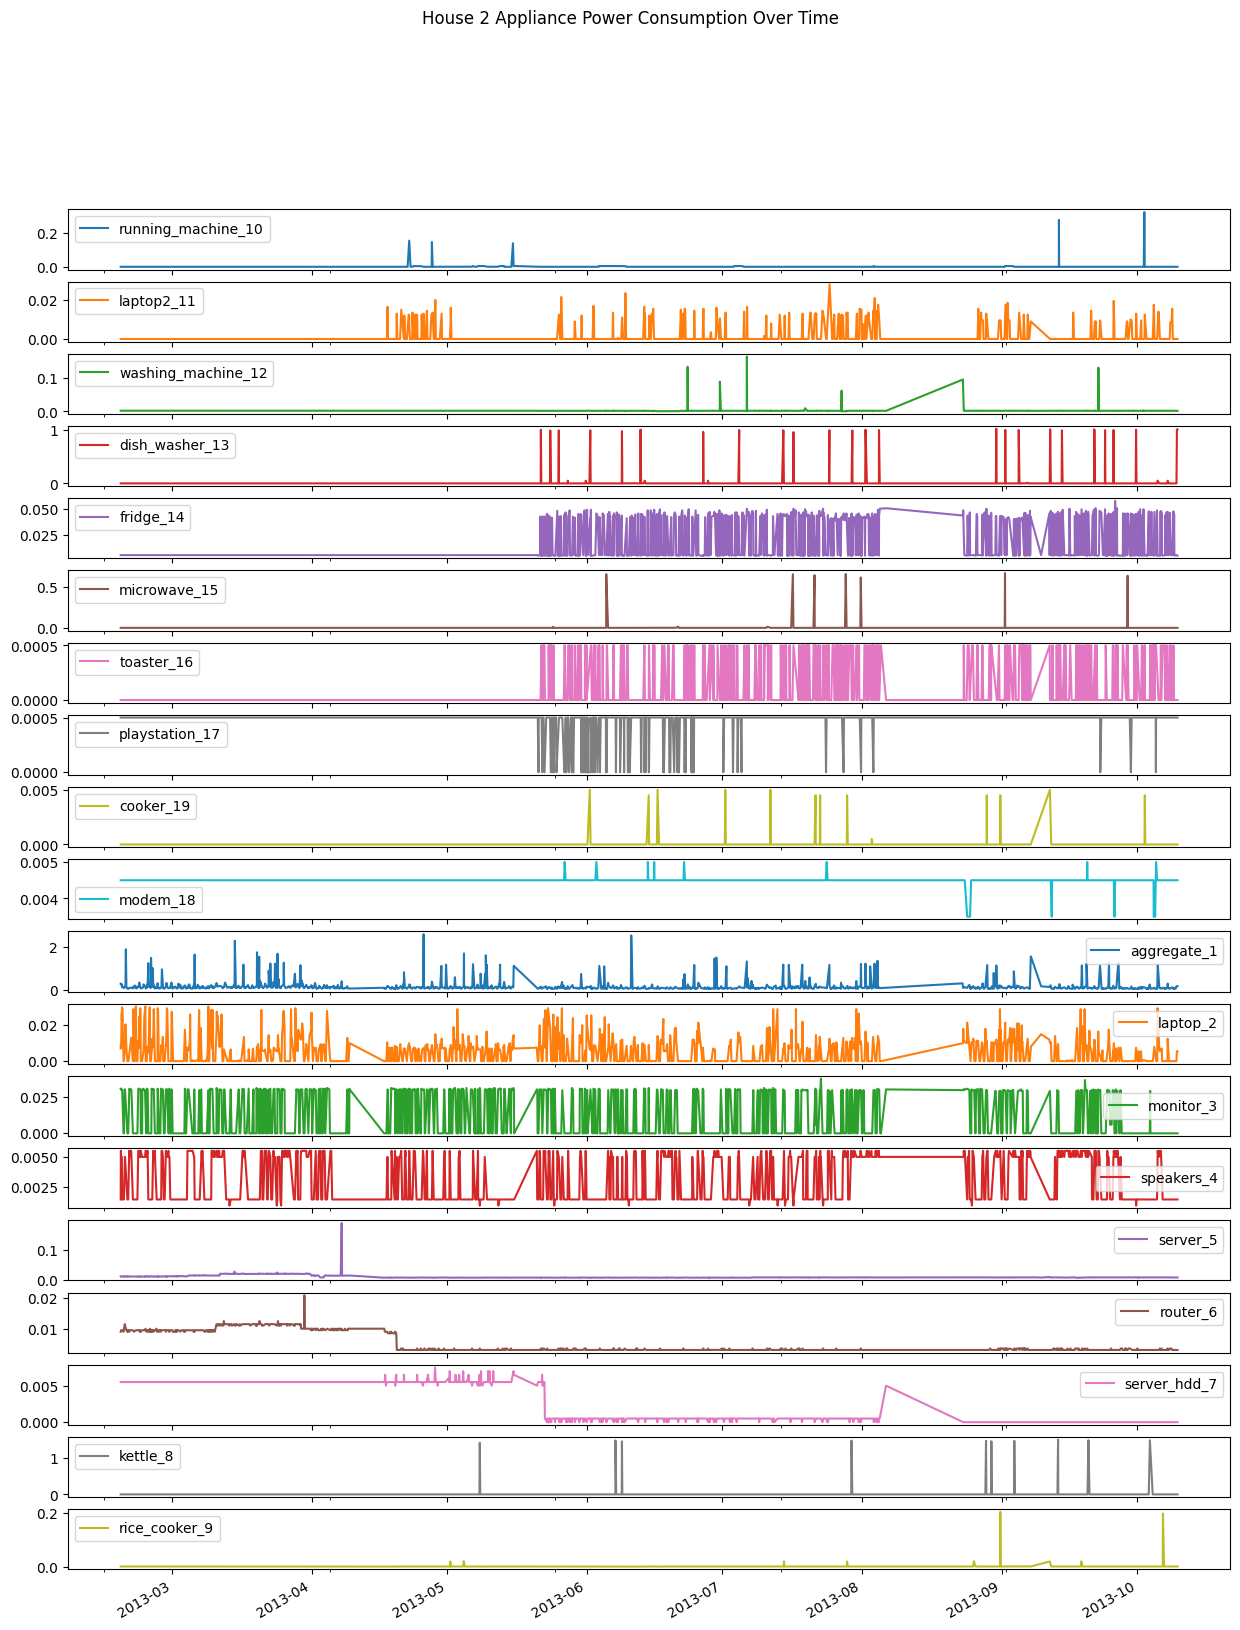

In [ ]:
df[2].plot(subplots=True, figsize=(15, 20), title='House 2 Appliance Power Consumption Over Time')
plt.show()

Seasonal Decomposition

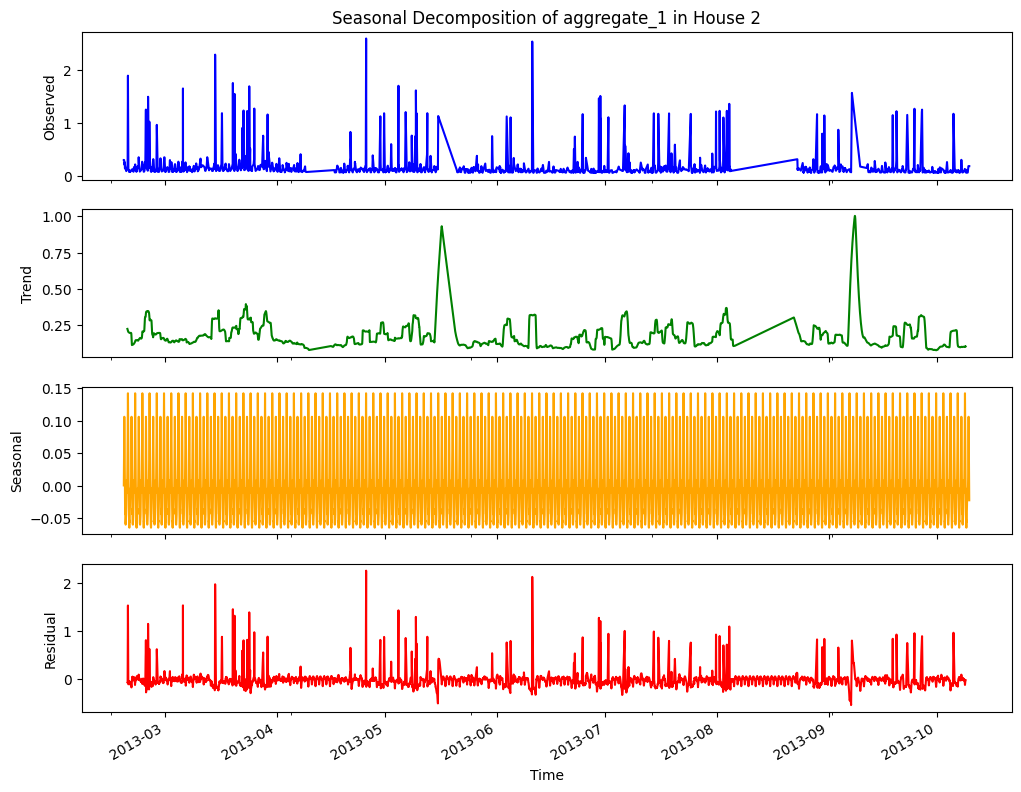

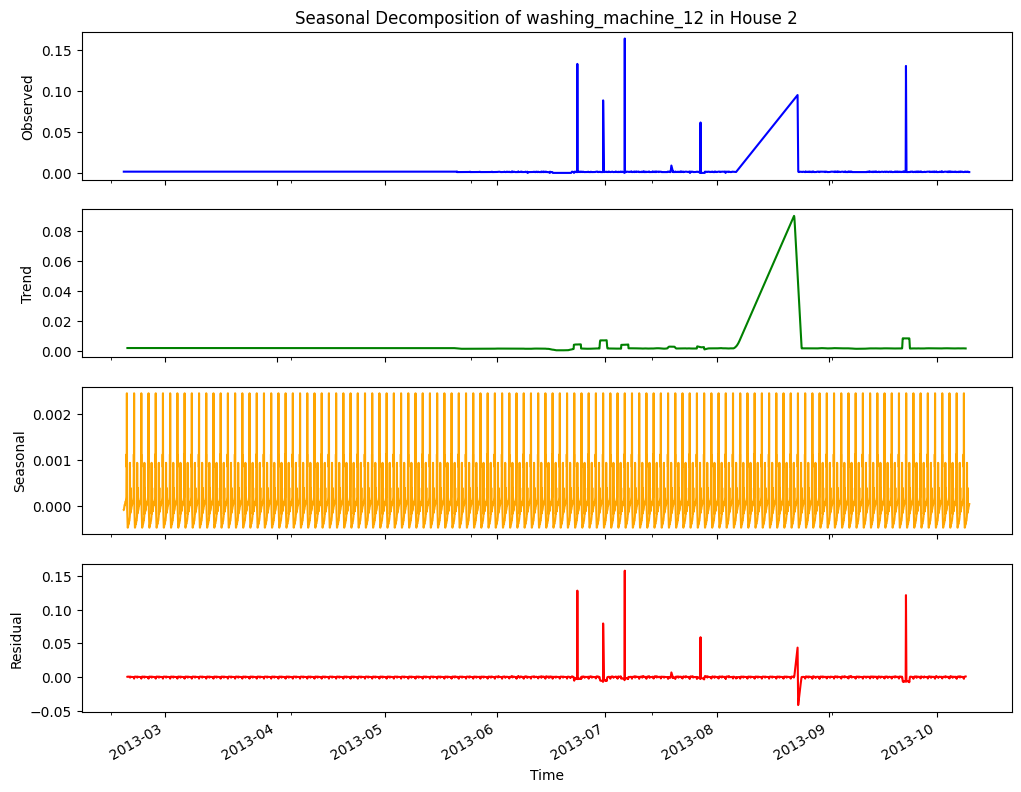

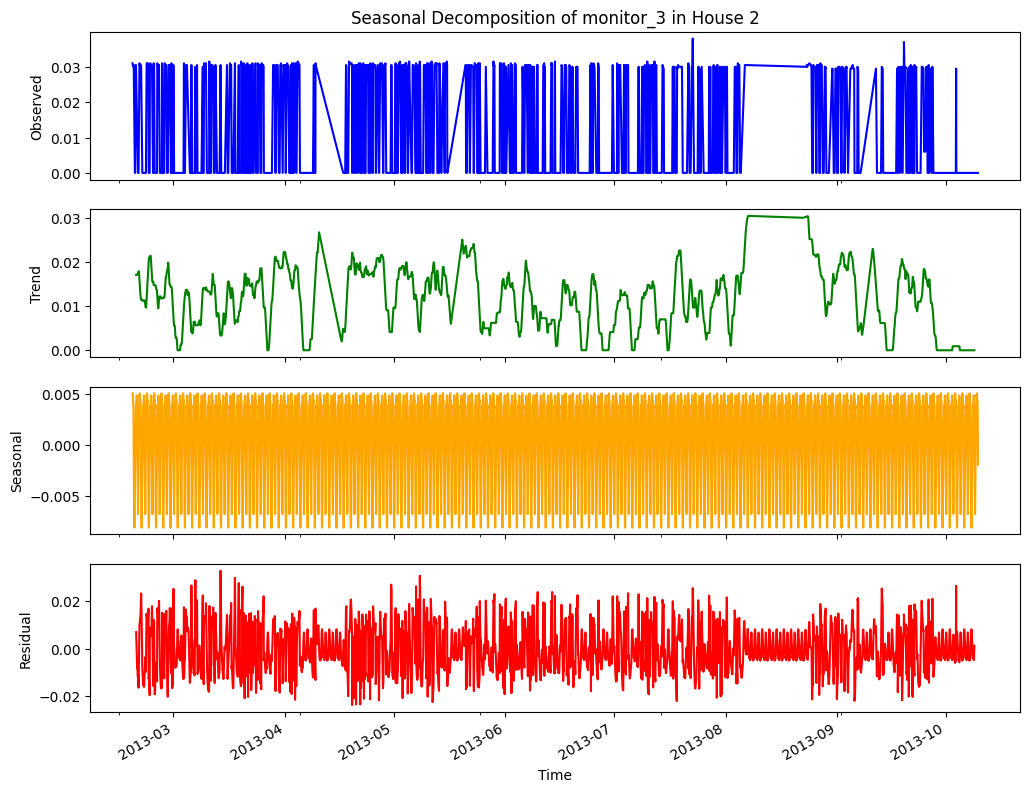

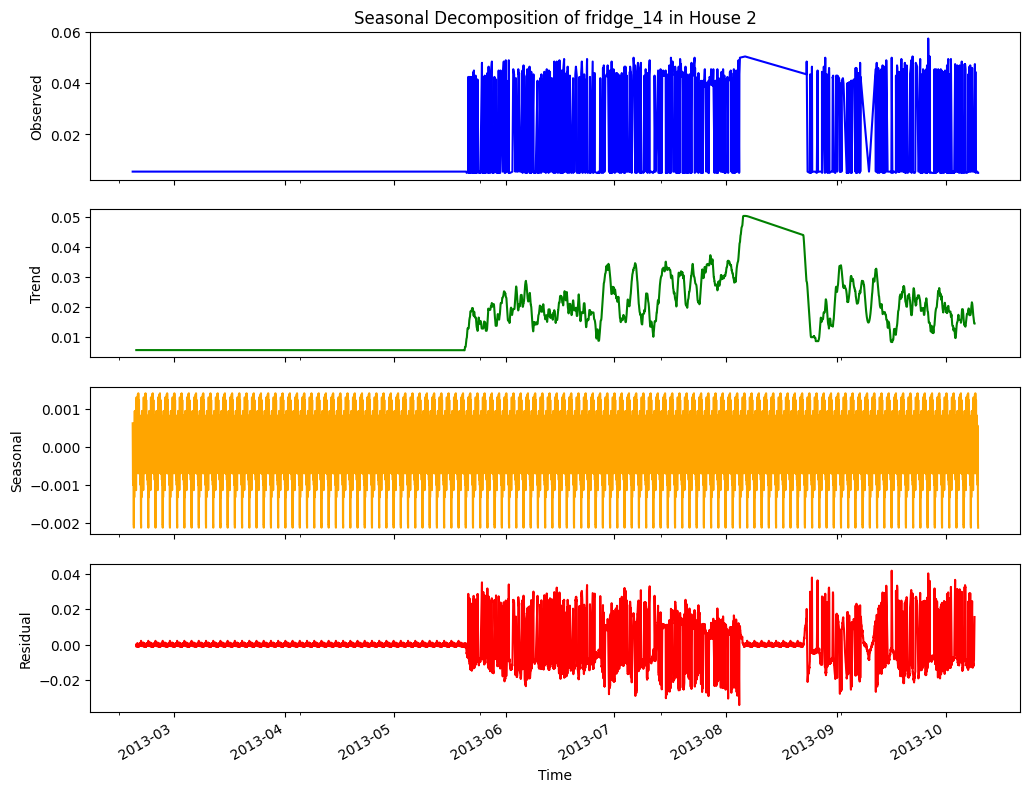

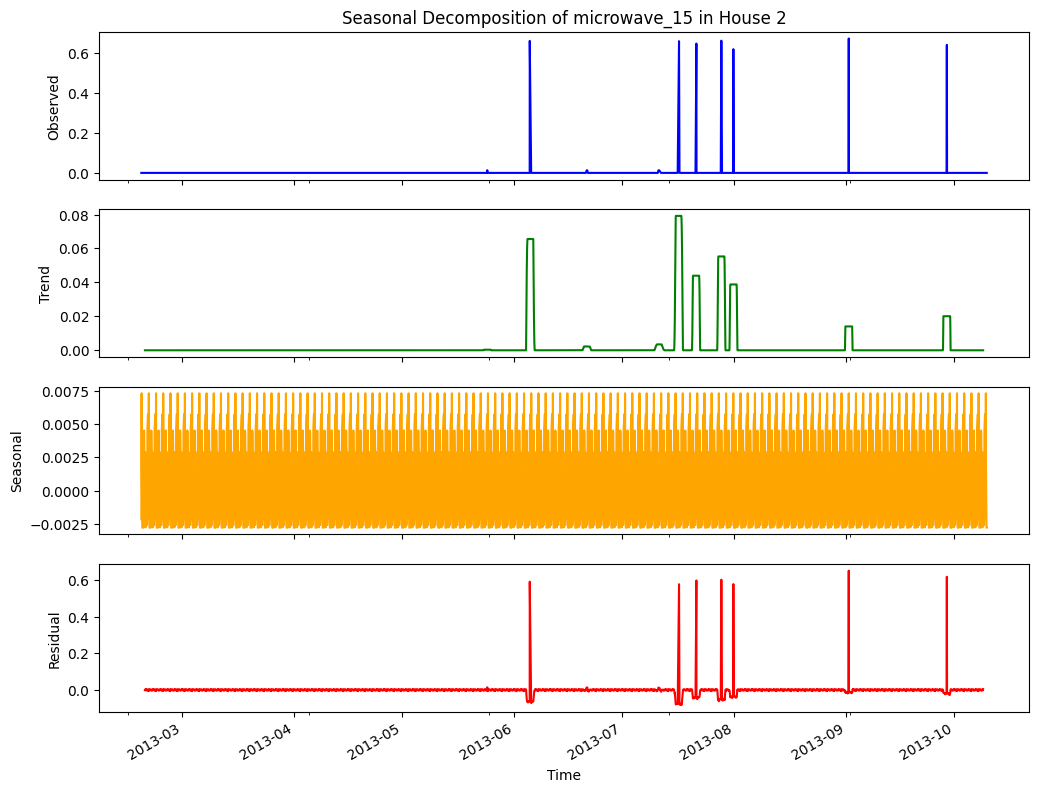

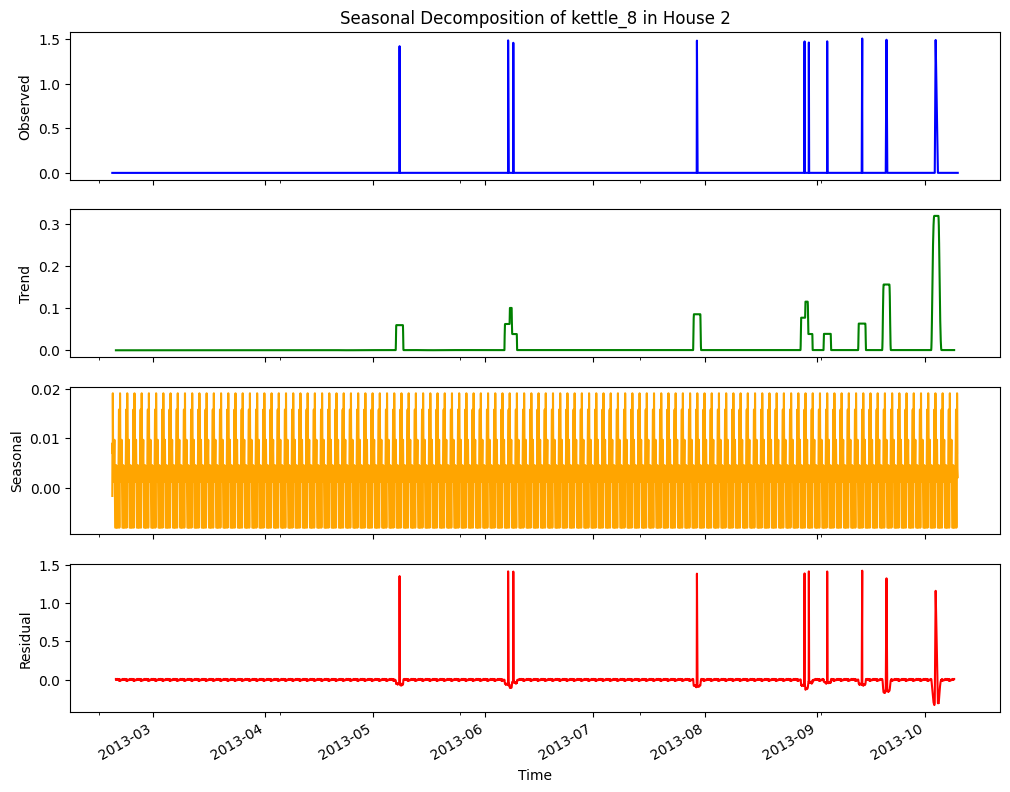

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# Define colors for each component
colors = {
    'observed': 'blue',
    'trend': 'green',
    'seasonal': 'orange',
    'resid': 'red'
}

# Seasonal decomposition function with improved plotting
def plot_seasonal_decomposition(series, period, title='Seasonal Decomposition'):
    result = seasonal_decompose(series.dropna(), model='additive', period=period)
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    result.observed.plot(ax=axes[0], color=colors['observed'])
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title)

    result.trend.plot(ax=axes[1], color=colors['trend'])
    axes[1].set_ylabel('Trend')

    result.seasonal.plot(ax=axes[2], color=colors['seasonal'])
    axes[2].set_ylabel('Seasonal')

    result.resid.plot(ax=axes[3], color=colors['resid'])
    axes[3].set_ylabel('Residual')

    plt.xlabel('Time')
    plt.show()

# Seasonal decomposition for key appliances in House 2
for appliance in key_appliances_per_house[2]:
    if appliance in df[2].columns:
        plot_seasonal_decomposition(df[2][appliance], period=96, title=f'Seasonal Decomposition of {appliance} in House 2')

Correlation Analysis

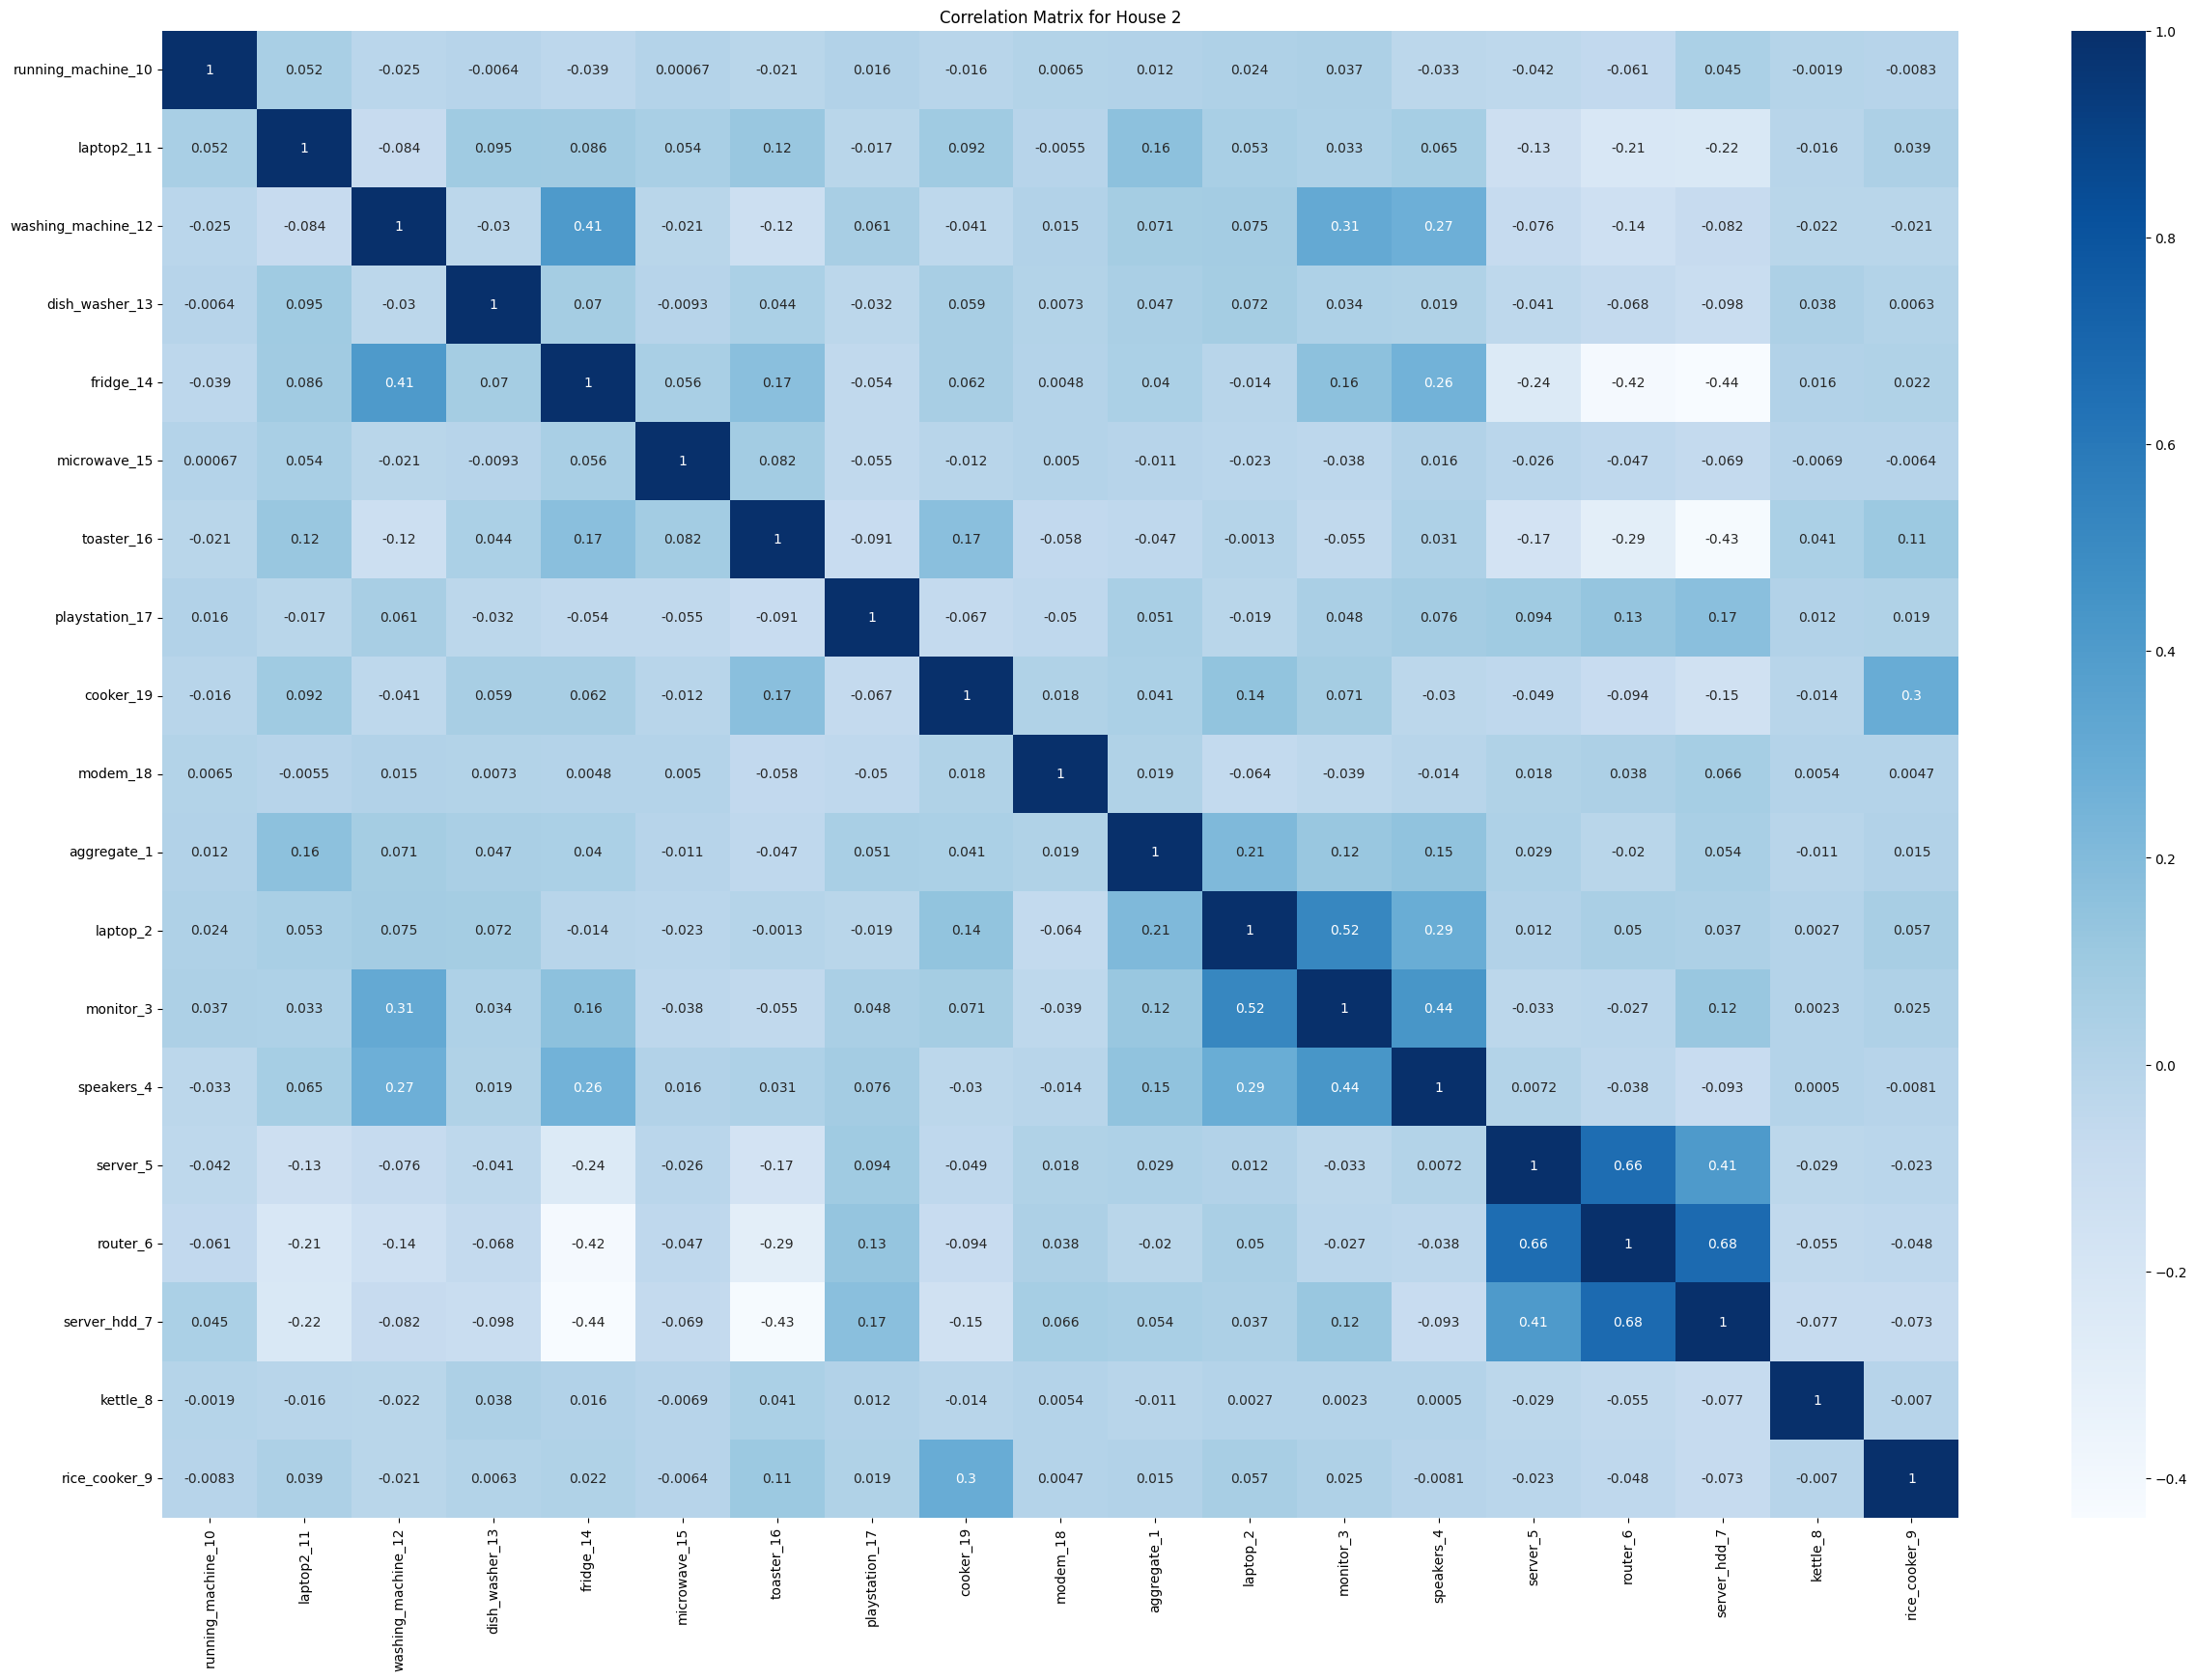

In [ ]:
corr_matrix = df[2].corr()
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix for House 2')
plt.show()

Daily Energy Consumption Distribution for Key Appliances

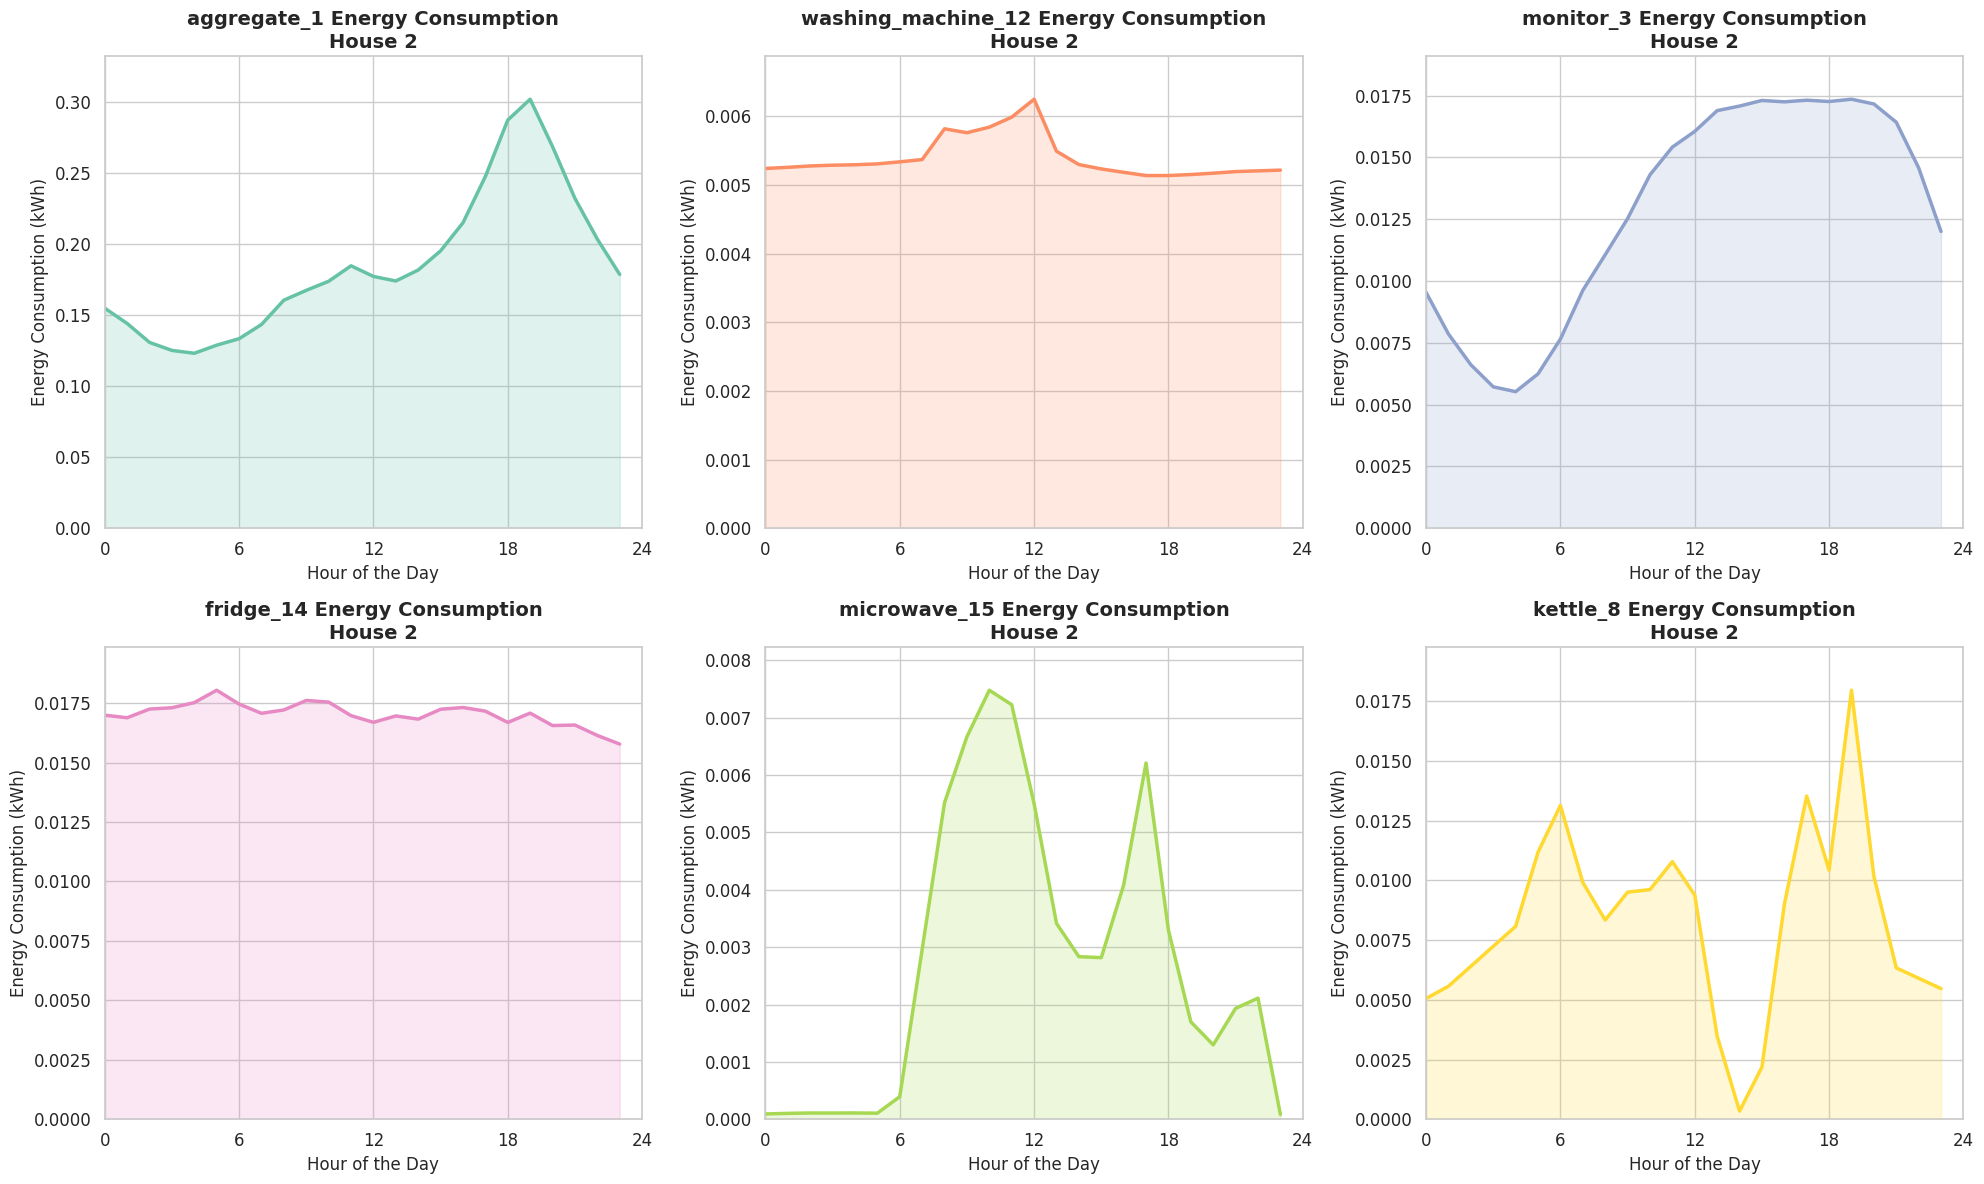

In [ ]:
# Plot daily energy consumption distribution curves
def plot_improved_daily_energy_distribution(df, appliances, house):
    plt.figure(figsize=(20, 12))
    sns.set(style="whitegrid")

    colors = sns.color_palette("Set2", len(appliances))

    for i, appliance in enumerate(appliances):
        if appliance in df.columns:
            # Resample to hourly data
            hourly_data = df[appliance].resample('H').mean()

            # Create a new DataFrame for hourly consumption aggregated by time of day
            hourly_mean = hourly_data.groupby(hourly_data.index.hour).mean()

            # Plot the distribution
            plt.subplot(2, 3, i + 1)
            sns.lineplot(x=hourly_mean.index, y=hourly_mean.values, color=colors[i], linewidth=2.5)
            plt.fill_between(hourly_mean.index, hourly_mean.values, alpha=0.2, color=colors[i])
            plt.xticks([0, 6, 12, 18, 24], fontsize=12)
            plt.yticks(fontsize=12)
            plt.title(f'{appliance} Energy Consumption\nHouse {house}', fontsize=14, fontweight='bold')
            plt.xlabel('Hour of the Day', fontsize=12)
            plt.ylabel('Energy Consumption (kWh)', fontsize=12)
            plt.xlim(0, 24)
            plt.ylim(0, max(hourly_mean.values) * 1.1)

    plt.tight_layout()
    plt.show()

# Specify the target house
target_house = 2

# Get the list of key appliances for the target house
appliances = key_appliances_per_house[target_house]

# Plot distribution curves for daily energy consumption for the key appliances
plot_improved_daily_energy_distribution(df[target_house], appliances, target_house)

### Data Pre-processing - Scaling and Sequence Creation for Models

In [ ]:
# Function to create sequences with timestamps
def create_sequences(data, timestamps, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        seq_timestamps = timestamps[i:i + seq_length]
        sequences.append((seq, label, seq_timestamps))
    return sequences

In [ ]:
# Preprocess data for LSTM with timestamps
def preprocess_data(df, seq_length=50):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    timestamps = df.index.to_numpy()
    sequences = create_sequences(scaled_data, timestamps, seq_length)
    X, y, seq_timestamps = zip(*sequences)
    X = np.array(X)
    y = np.array(y)
    seq_timestamps = np.array(seq_timestamps)
    return X, y, seq_timestamps, scaler

## Model Implementation

## LSTM (Long Short-Term Memory)

Predicting consumption for aggregate_1 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.3329
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0962
Epoch 3/10
140/140 [==============================] - 1s 10ms/step - loss: 0.0736
Epoch 4/10
140/140 [==============================] - 1s 10ms/step - loss: 0.0717
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0706
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0697
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0724
Epoch 8/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0690
Epoch 9/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0694
Epoch 10/10
70/70 [==============================] - 1s 4ms/step
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.3141
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - lo

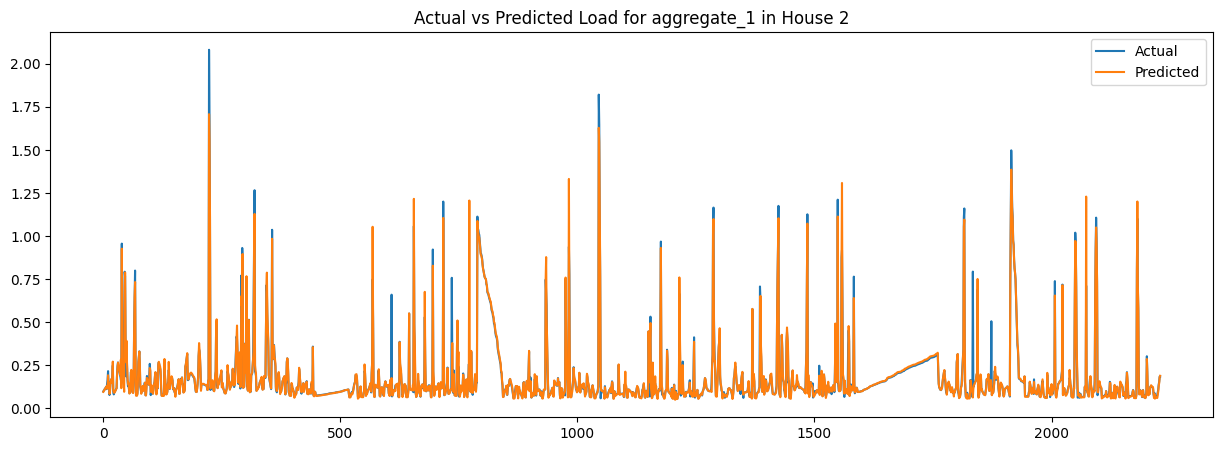

First 5 actual vs predicted values for aggregate_1 in House 2:
Actual: 0.098, Predicted: 0.09580164402723312
Actual: 0.1035, Predicted: 0.1017293781042099
Actual: 0.10533333333333333, Predicted: 0.10369637608528137
Actual: 0.11266666666666665, Predicted: 0.11154284328222275
Actual: 0.11633333333333333, Predicted: 0.11545875668525696
Predicting consumption for washing_machine_12 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 10ms/step - loss: 0.1298
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0450
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0299
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0258
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0245
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0233
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0233
Epoch 8/10
140/140 [=================

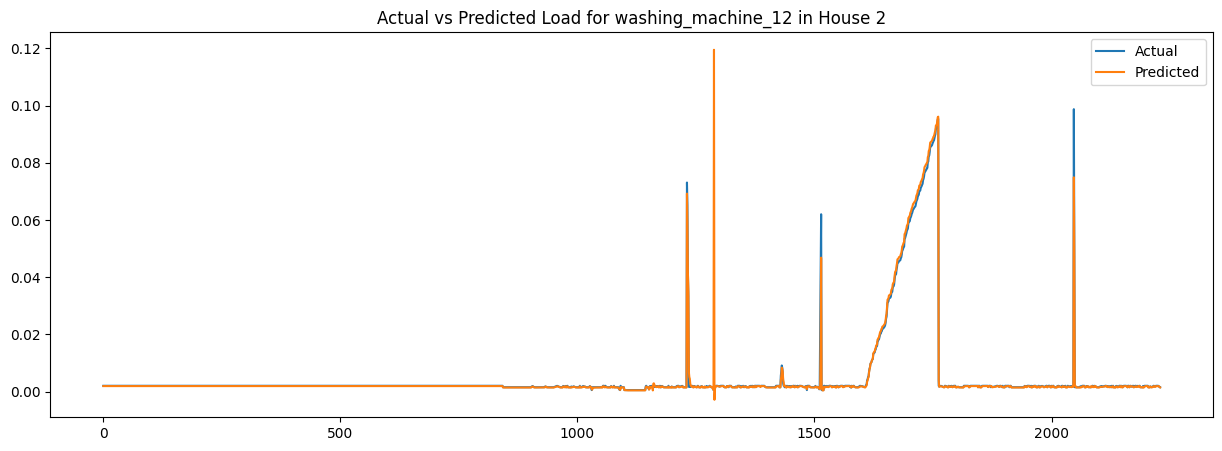

First 5 actual vs predicted values for washing_machine_12 in House 2:
Actual: 0.002, Predicted: 0.0018973550759255886
Actual: 0.002, Predicted: 0.0018973550759255886
Actual: 0.002, Predicted: 0.0018973550759255886
Actual: 0.002, Predicted: 0.0018973550759255886
Actual: 0.002, Predicted: 0.0018973550759255886
Predicting consumption for monitor_3 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.2061
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0410
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0353
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0331
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0322
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0314
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 8/10
140/140 [==============================] - 1s 9ms/step - loss

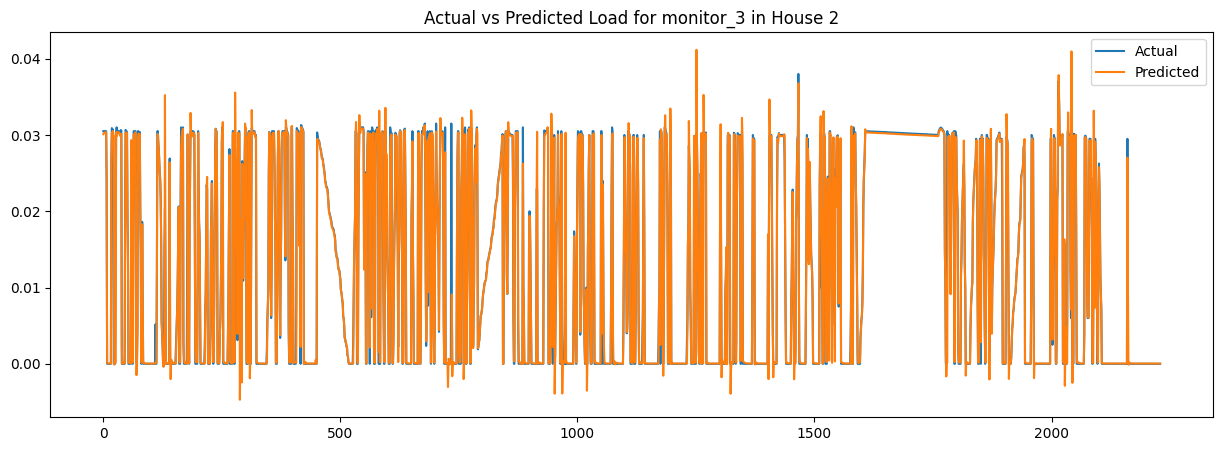

First 5 actual vs predicted values for monitor_3 in House 2:
Actual: 0.0305, Predicted: 0.030106067657470703
Actual: 0.0305, Predicted: 0.030215734615921974
Actual: 0.0305, Predicted: 0.030246688053011894
Actual: 0.0305, Predicted: 0.030322879552841187
Actual: 0.0305, Predicted: 0.03033638745546341
Predicting consumption for fridge_14 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.2767
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1084
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0981
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0953
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0937
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0946
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0910
Epoch 8/10
140/140 [==============================] - 1s 10ms/step - loss: 0.0897


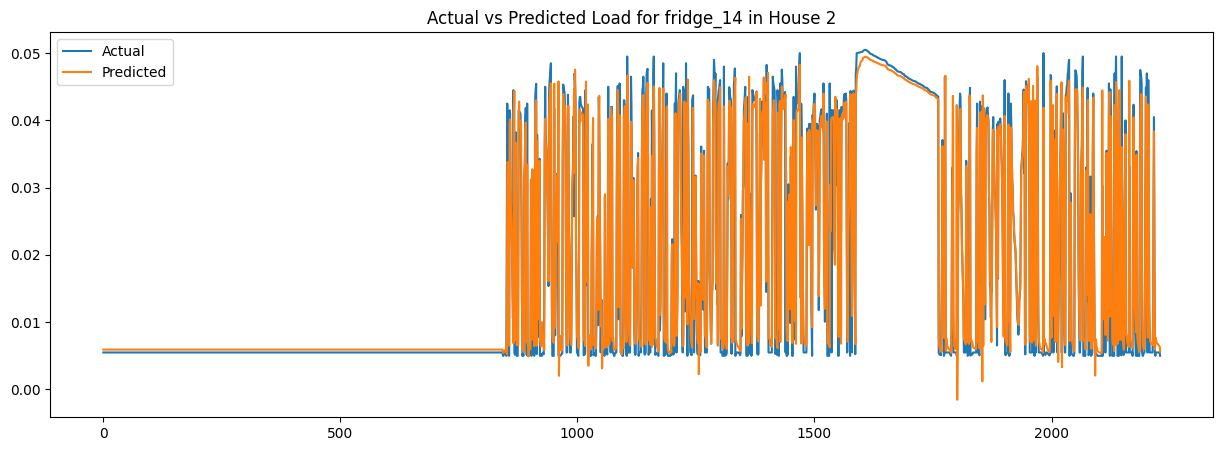

First 5 actual vs predicted values for fridge_14 in House 2:
Actual: 0.0055, Predicted: 0.005932397209107876
Actual: 0.0055, Predicted: 0.005932397209107876
Actual: 0.0055, Predicted: 0.005932397209107876
Actual: 0.0055, Predicted: 0.005932397209107876
Actual: 0.0055, Predicted: 0.005932397209107876
Predicting consumption for microwave_15 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.5570
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.2383
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1680
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1312
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1179
Epoch 6/10
140/140 [==============================] - 1s 10ms/step - loss: 0.1124
Epoch 7/10
140/140 [==============================] - 1s 10ms/step - loss: 0.1102
Epoch 8/10
140/140 [==============================] - 1s 10ms/step - loss: 0

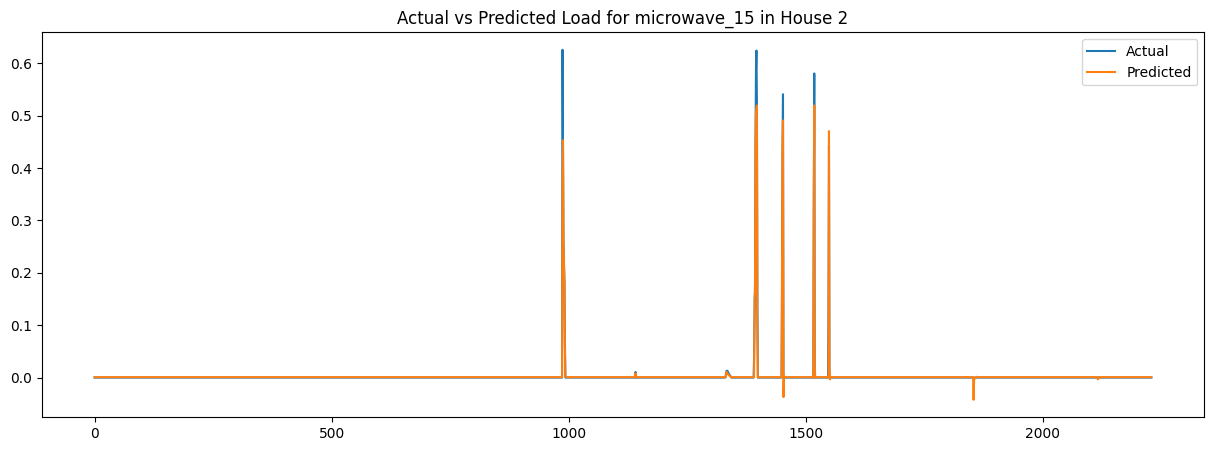

First 5 actual vs predicted values for microwave_15 in House 2:
Actual: 0.0, Predicted: 0.0008155797841027379
Actual: 0.0, Predicted: 0.0008155797841027379
Actual: 0.0, Predicted: 0.0008155797841027379
Actual: 0.0, Predicted: 0.0008155797841027379
Actual: 0.0, Predicted: 0.0008155797841027379
Predicting consumption for kettle_8 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.6033
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.2577
Epoch 3/10
140/140 [==============================] - 1s 10ms/step - loss: 0.1779
Epoch 4/10
140/140 [==============================] - 1s 10ms/step - loss: 0.1528
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1428
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1421
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1397
Epoch 8/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1396
Epoch 

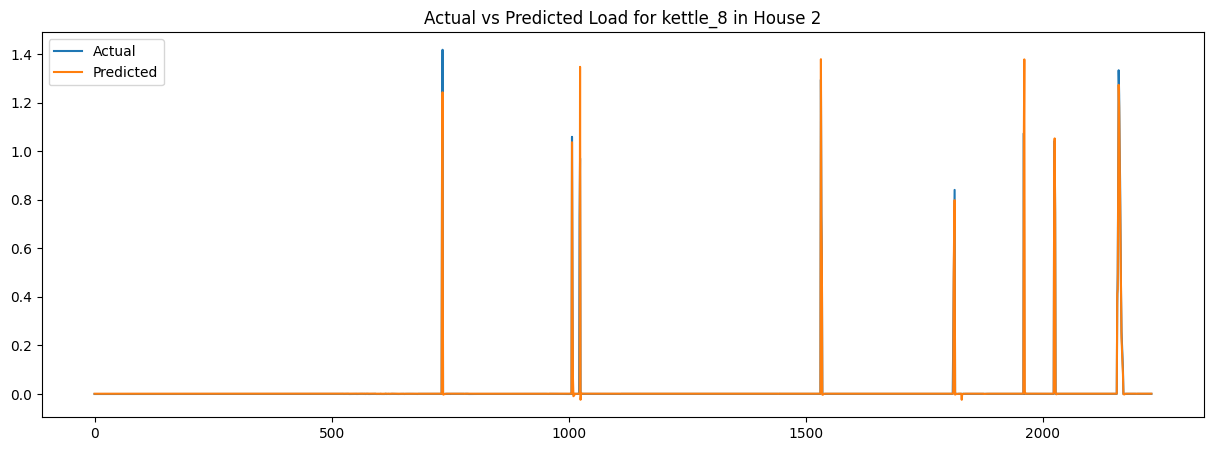

First 5 actual vs predicted values for kettle_8 in House 2:
Actual: 0.0, Predicted: 0.0010848166421055794
Actual: 0.0, Predicted: 0.0010848166421055794
Actual: 0.0, Predicted: 0.0010848166421055794
Actual: 0.0, Predicted: 0.0010848166421055794
Actual: 0.0, Predicted: 0.0010848166421055794


In [ ]:
# Specify the target house
target_house = 2  # Change this to the desired house number

# Train and evaluate for the target house
house_data = df[target_house]
appliances = key_appliances_per_house[target_house]

results = {}

# Add cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for appliance in appliances:
    if appliance in house_data.columns:
        print(f"Predicting consumption for {appliance} in House {target_house}...")

        # Use the selected appliance's power consumption for forecasting
        df_load = house_data[[appliance]]

        # Preprocess data
        seq_length = 96  # 48 hours in 30-minute intervals
        X, y, seq_timestamps, scaler = preprocess_data(df_load, seq_length)

        cv_mse, cv_mae, cv_r2 = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Build and train LSTM model
            model = Sequential()
            model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
            model.add(LSTM(50))
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
            model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

            # Make predictions
            y_pred = model.predict(X_test)

            # Inverse transform predictions
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)

            # Evaluation metrics
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            r2 = r2_score(y_test_inv, y_pred_inv)

            cv_mse.append(mse)
            cv_mae.append(mae)
            cv_r2.append(r2)

        print(f'{appliance} - CV MSE: {np.mean(cv_mse)}, CV MAE: {np.mean(cv_mae)}, CV R²: {np.mean(cv_r2)}')

        # Plot actual vs predicted values
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(y_pred_inv, label='Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted Load for {appliance} in House {target_house}')
        plt.show()

        # Print 5 actual vs predicted values
        print(f"First 5 actual vs predicted values for {appliance} in House {target_house}:")
        for i in range(5):
            print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

        # Store results
        results[f'House {target_house} - {appliance}'] = {'cv_mse': np.mean(cv_mse), 'cv_mae': np.mean(cv_mae), 'cv_r2': np.mean(cv_r2)}

### Model Evaluation of LSTM

In [ ]:
# Print summary of results
for key, metrics in results.items():
    print(f"{key} - CV MSE: {metrics['cv_mse']}, CV MAE: {metrics['cv_mae']}, CV R²: {metrics['cv_r2']}")

House 2 - aggregate_1 - CV MSE: 0.0034683242762933407, CV MAE: 0.013339464129711149, CV R²: 0.9239562276573435
House 2 - washing_machine_12 - CV MSE: 8.189809817276667e-06, CV MAE: 0.0003002558164729108, CV R²: 0.96357308688281
House 2 - monitor_3 - CV MSE: 4.604704692874705e-06, CV MAE: 0.0008337499707636146, CV R²: 0.9734382885648449
House 2 - fridge_14 - CV MSE: 2.0642373789537828e-05, CV MAE: 0.0016997844894461652, CV R²: 0.9229704237449579
House 2 - microwave_15 - CV MSE: 0.00013379960313317723, CV MAE: 0.001353474877679834, CV R²: 0.9098553460858205
House 2 - kettle_8 - CV MSE: 0.0008856951604194361, CV MAE: 0.0031521718608571933, CV R²: 0.8967756166606689


## Random Forest

Predicting consumption for aggregate_1 in House 2...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
aggregate_1 - Best Params: {'max_depth': 30, 'n_estimators': 200}
aggregate_1 - CV MSE: 0.004076861211312072, CV MAE: 0.013576668805165653, CV R²: 0.9107341286101809


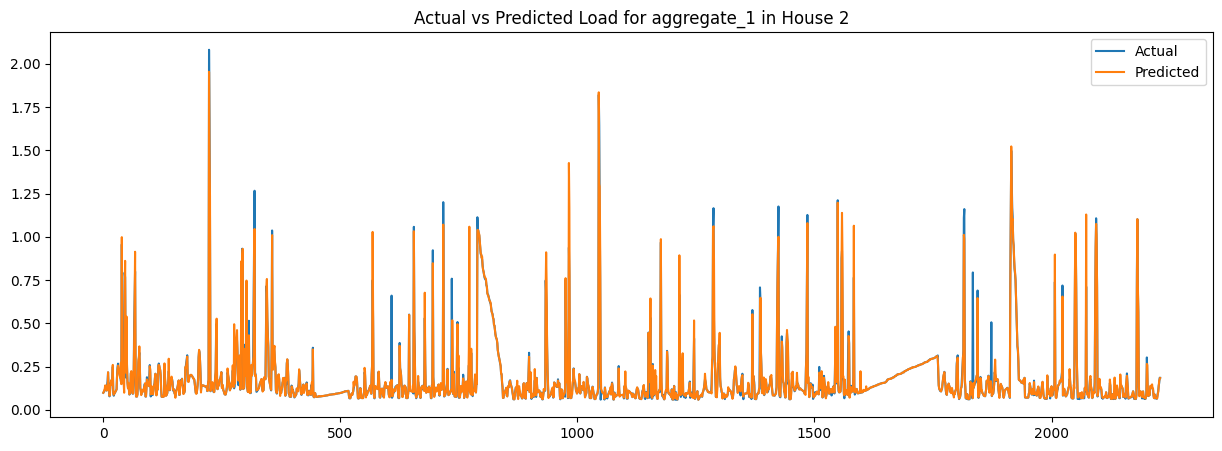

First 5 actual vs predicted values for aggregate_1 in House 2:
Actual: 0.098, Predicted: 0.09845643266376286
Actual: 0.1035, Predicted: 0.10349762270541862
Actual: 0.10533333333333333, Predicted: 0.11421235229239143
Actual: 0.11266666666666665, Predicted: 0.12096331495355431
Actual: 0.11633333333333333, Predicted: 0.14090722436042818
Predicting consumption for washing_machine_12 in House 2...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
washing_machine_12 - Best Params: {'max_depth': 20, 'n_estimators': 200}
washing_machine_12 - CV MSE: 7.965547796318929e-06, CV MAE: 0.00018409283307623583, CV R²: 0.9628161174271721


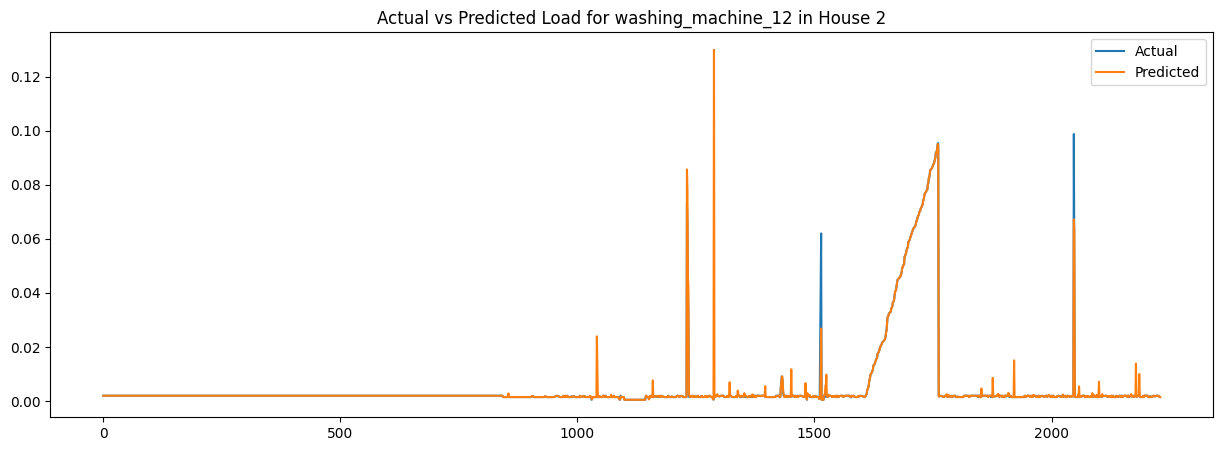

First 5 actual vs predicted values for washing_machine_12 in House 2:
Actual: 0.002, Predicted: 0.0019999396176099316
Actual: 0.002, Predicted: 0.0019999396176099316
Actual: 0.002, Predicted: 0.0019999396176099316
Actual: 0.002, Predicted: 0.0019999396176099316
Actual: 0.002, Predicted: 0.0019999396176099316
Predicting consumption for monitor_3 in House 2...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
monitor_3 - Best Params: {'max_depth': 10, 'n_estimators': 200}
monitor_3 - CV MSE: 3.769374538247037e-06, CV MAE: 0.0005500928191317811, CV R²: 0.9782518564651109


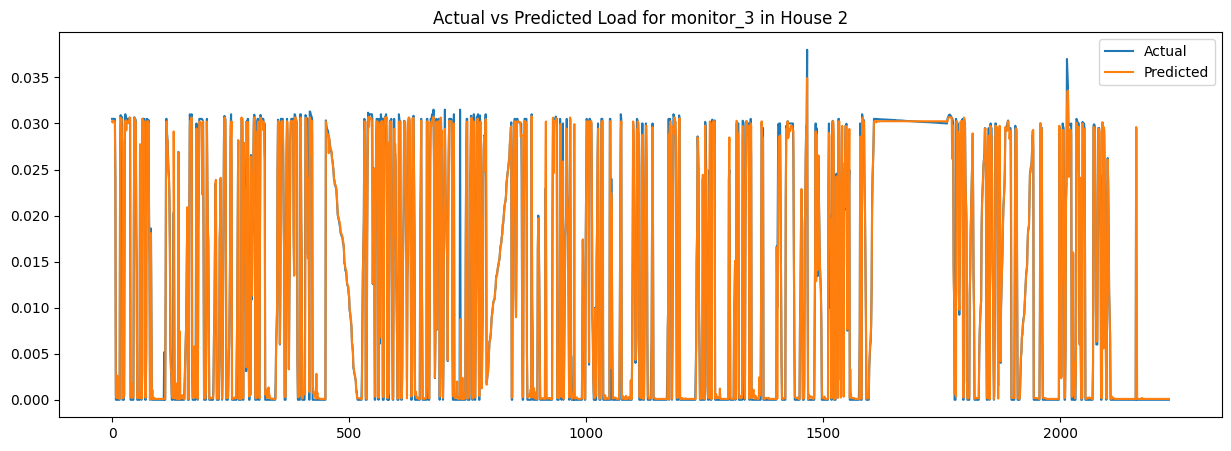

First 5 actual vs predicted values for monitor_3 in House 2:
Actual: 0.0305, Predicted: 0.030237909694172393
Actual: 0.0305, Predicted: 0.03009750853108339
Actual: 0.0305, Predicted: 0.030246741290319547
Actual: 0.0305, Predicted: 0.030244642897498075
Actual: 0.0305, Predicted: 0.030243755259806056
Predicting consumption for fridge_14 in House 2...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
fridge_14 - Best Params: {'max_depth': 10, 'n_estimators': 200}
fridge_14 - CV MSE: 1.6298359776161756e-05, CV MAE: 0.0012332393641780615, CV R²: 0.939217977737836


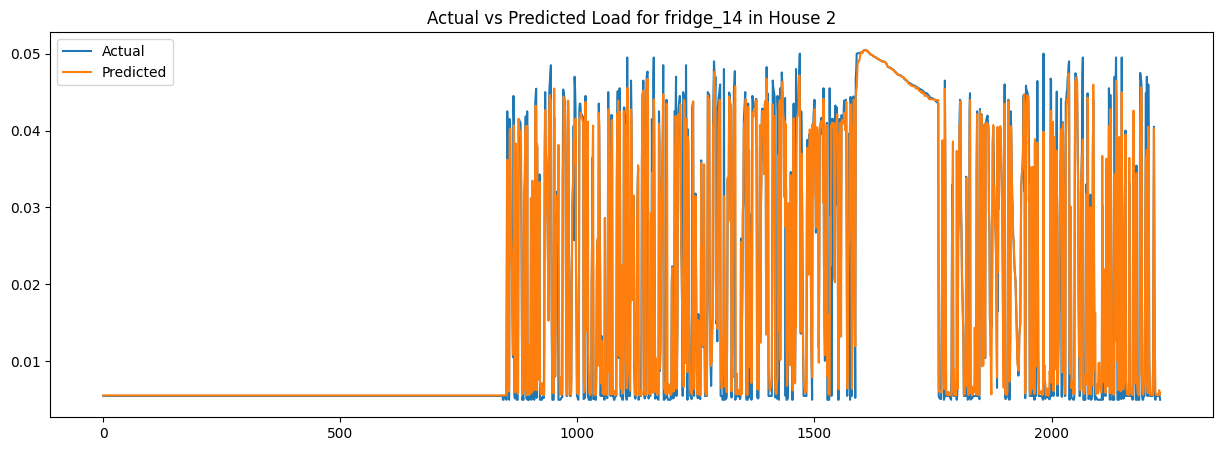

First 5 actual vs predicted values for fridge_14 in House 2:
Actual: 0.0055, Predicted: 0.00556879540787034
Actual: 0.0055, Predicted: 0.00556879540787034
Actual: 0.0055, Predicted: 0.00556879540787034
Actual: 0.0055, Predicted: 0.00556879540787034
Actual: 0.0055, Predicted: 0.00556879540787034
Predicting consumption for microwave_15 in House 2...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
microwave_15 - Best Params: {'max_depth': 10, 'n_estimators': 200}
microwave_15 - CV MSE: 0.00020179002436167176, CV MAE: 0.0008678916929725049, CV R²: 0.8543178223693271


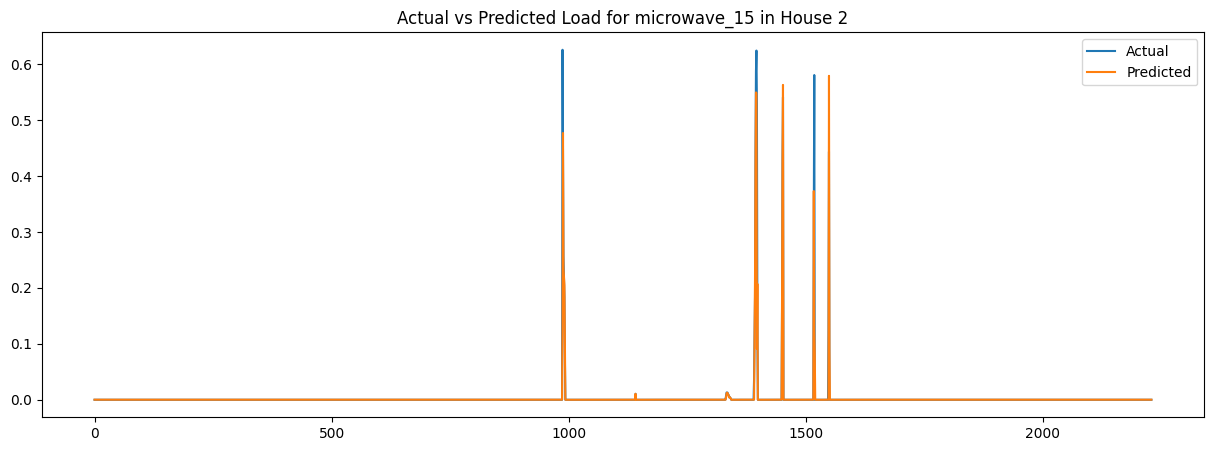

First 5 actual vs predicted values for microwave_15 in House 2:
Actual: 0.0, Predicted: 0.00014042394138270636
Actual: 0.0, Predicted: 0.00014042394138270636
Actual: 0.0, Predicted: 0.00014042394138270636
Actual: 0.0, Predicted: 0.00014042394138270636
Actual: 0.0, Predicted: 0.00014042394138270636
Predicting consumption for kettle_8 in House 2...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
kettle_8 - Best Params: {'max_depth': 30, 'n_estimators': 200}
kettle_8 - CV MSE: 0.0011009543046905396, CV MAE: 0.0027413369143932617, CV R²: 0.8664041744025297


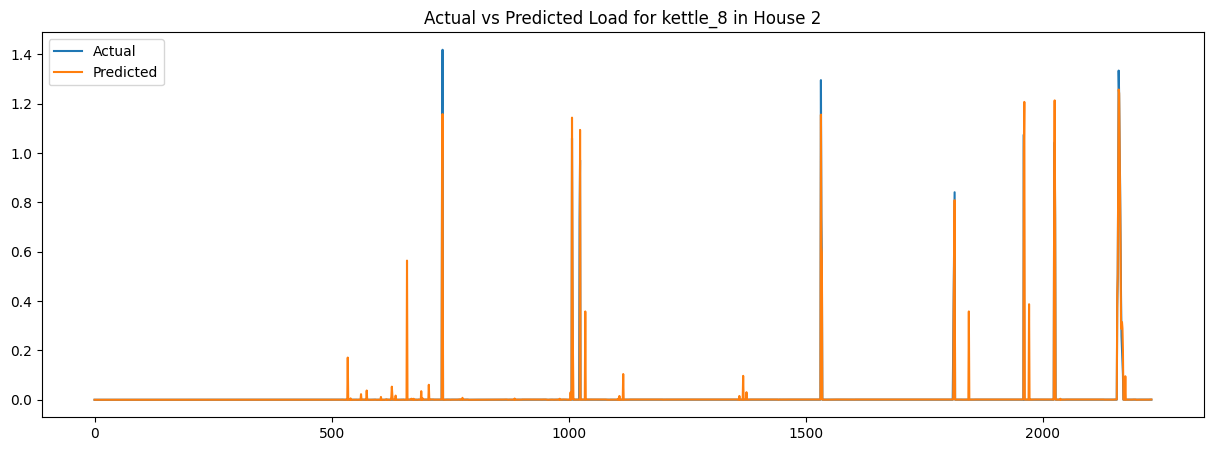

First 5 actual vs predicted values for kettle_8 in House 2:
Actual: 0.0, Predicted: 2.636779683484747e-16
Actual: 0.0, Predicted: 2.636779683484747e-16
Actual: 0.0, Predicted: 2.636779683484747e-16
Actual: 0.0, Predicted: 2.636779683484747e-16
Actual: 0.0, Predicted: 2.636779683484747e-16


In [ ]:
# Preprocess data for Random Forest with timestamps
def preprocess_data(df, seq_length=50):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    timestamps = df.index.to_numpy()
    sequences = create_sequences(scaled_data, timestamps, seq_length)
    X, y, seq_timestamps = zip(*sequences)
    X = np.array(X)
    y = np.array(y)
    seq_timestamps = np.array(seq_timestamps)
    return X, y, seq_timestamps, scaler

# Specify the target house
target_house = 2  # Change this to the desired house number

# Train and evaluate for the target house
house_data = df[target_house]
appliances = key_appliances_per_house[target_house]

results = {}

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30]
}

# Add cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for appliance in appliances:
    if appliance in house_data.columns:
        print(f"Predicting consumption for {appliance} in House {target_house}...")

        # Use the selected appliance's power consumption for forecasting
        df_load = house_data[[appliance]]

        # Preprocess data
        seq_length = 96  # 48 hours in 30-minute intervals
        X, y, seq_timestamps, scaler = preprocess_data(df_load, seq_length)

        # Flatten the sequences for Random Forest
        X_flattened = X.reshape(X.shape[0], -1)

        # Initialize the model
        rf = RandomForestRegressor(random_state=42)

        # GridSearchCV
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
        grid_search.fit(X_flattened, y)

        best_model = grid_search.best_estimator_

        # Cross-validation metrics
        cv_mse, cv_mae, cv_r2 = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Flatten the sequences for Random Forest
            X_train_flattened = X_train.reshape(X_train.shape[0], -1)
            X_test_flattened = X_test.reshape(X_test.shape[0], -1)

            # Train the best model
            best_model.fit(X_train_flattened, y_train)

            # Make predictions
            y_pred = best_model.predict(X_test_flattened)

            # Inverse transform predictions
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

            # Evaluation metrics
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            r2 = r2_score(y_test_inv, y_pred_inv)

            cv_mse.append(mse)
            cv_mae.append(mae)
            cv_r2.append(r2)

        print(f'{appliance} - Best Params: {grid_search.best_params_}')
        print(f'{appliance} - CV MSE: {np.mean(cv_mse)}, CV MAE: {np.mean(cv_mae)}, CV R²: {np.mean(cv_r2)}')

        # Plot actual vs predicted values
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(y_pred_inv, label='Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted Load for {appliance} in House {target_house}')
        plt.show()

        # Print 5 actual vs predicted values
        print(f"First 5 actual vs predicted values for {appliance} in House {target_house}:")
        for i in range(5):
            print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

        # Store results
        results[f'House {target_house} - {appliance}'] = {
            'best_params': grid_search.best_params_,
            'cv_mse': np.mean(cv_mse),
            'cv_mae': np.mean(cv_mae),
            'cv_r2': np.mean(cv_r2)
        }

### Model Evaluation of Random Forest

In [ ]:
# Print summary of results
for key, metrics in results.items():
    print(f"{key} - MSE: {metrics['cv_mse']}, MAE: {metrics['cv_mae']}, R²: {metrics['cv_r2']}")

House 2 - aggregate_1 - MSE: 0.004076861211312072, MAE: 0.013576668805165653, R²: 0.9107341286101809
House 2 - washing_machine_12 - MSE: 7.965547796318929e-06, MAE: 0.00018409283307623583, R²: 0.9628161174271721
House 2 - monitor_3 - MSE: 3.769374538247037e-06, MAE: 0.0005500928191317811, R²: 0.9782518564651109
House 2 - fridge_14 - MSE: 1.6298359776161756e-05, MAE: 0.0012332393641780615, R²: 0.939217977737836
House 2 - microwave_15 - MSE: 0.00020179002436167176, MAE: 0.0008678916929725049, R²: 0.8543178223693271
House 2 - kettle_8 - MSE: 0.0011009543046905396, MAE: 0.0027413369143932617, R²: 0.8664041744025297


## Linear Regression

Predicting consumption for aggregate_1 in House 2...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
aggregate_1 - Best Params: {'fit_intercept': False}
aggregate_1 - CV MSE: 0.0043683531512560565, CV MAE: 0.018557103838921573, CV R²: 0.9039223987287045


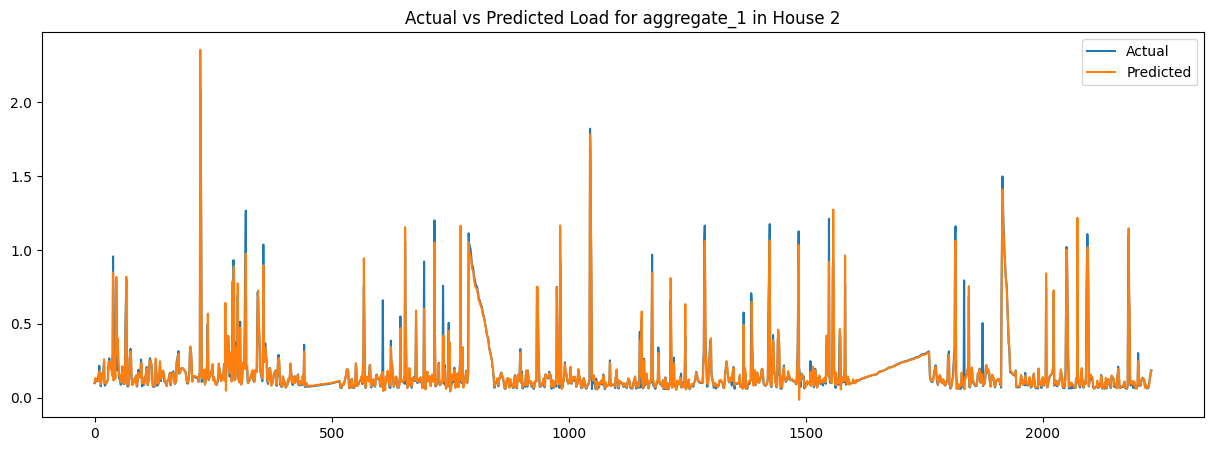

First 5 actual vs predicted values for aggregate_1 in House 2:
Actual: 0.098, Predicted: 0.10333281189692368
Actual: 0.1035, Predicted: 0.1174215669887185
Actual: 0.10533333333333333, Predicted: 0.13411728291537733
Actual: 0.11266666666666665, Predicted: 0.1253613798602553
Actual: 0.11633333333333333, Predicted: 0.12225595278616971
Predicting consumption for washing_machine_12 in House 2...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
washing_machine_12 - Best Params: {'fit_intercept': False}
washing_machine_12 - CV MSE: 8.191197095411613e-06, CV MAE: 0.00024353367691627367, CV R²: 0.9615926684253685


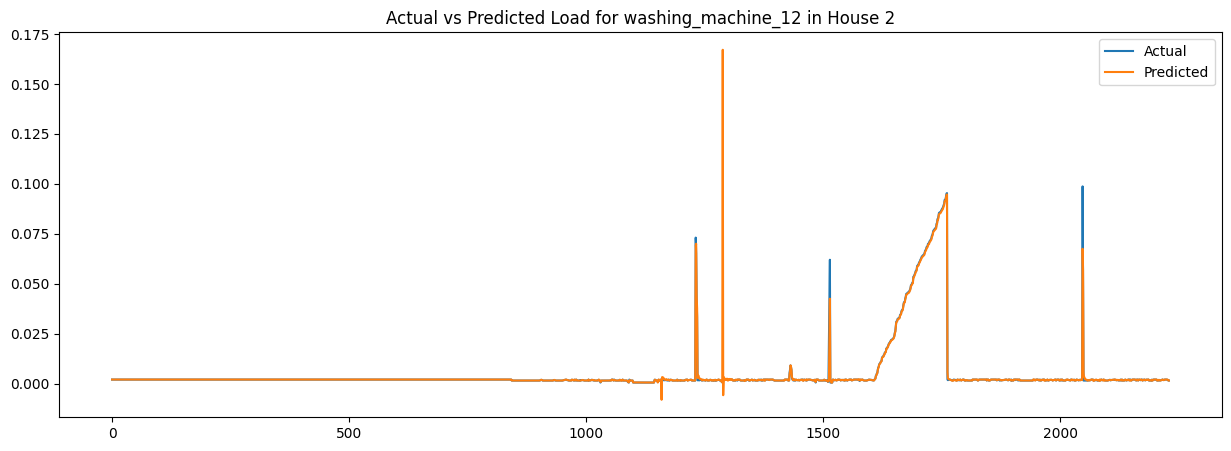

First 5 actual vs predicted values for washing_machine_12 in House 2:
Actual: 0.002, Predicted: 0.0020184035697432406
Actual: 0.002, Predicted: 0.0020184035697432406
Actual: 0.002, Predicted: 0.0020184035697432406
Actual: 0.002, Predicted: 0.0020184035697432406
Actual: 0.002, Predicted: 0.0020184035697432406
Predicting consumption for monitor_3 in House 2...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
monitor_3 - Best Params: {'fit_intercept': False}
monitor_3 - CV MSE: 5.356603640325662e-06, CV MAE: 0.0010175353923063185, CV R²: 0.9691041537265919


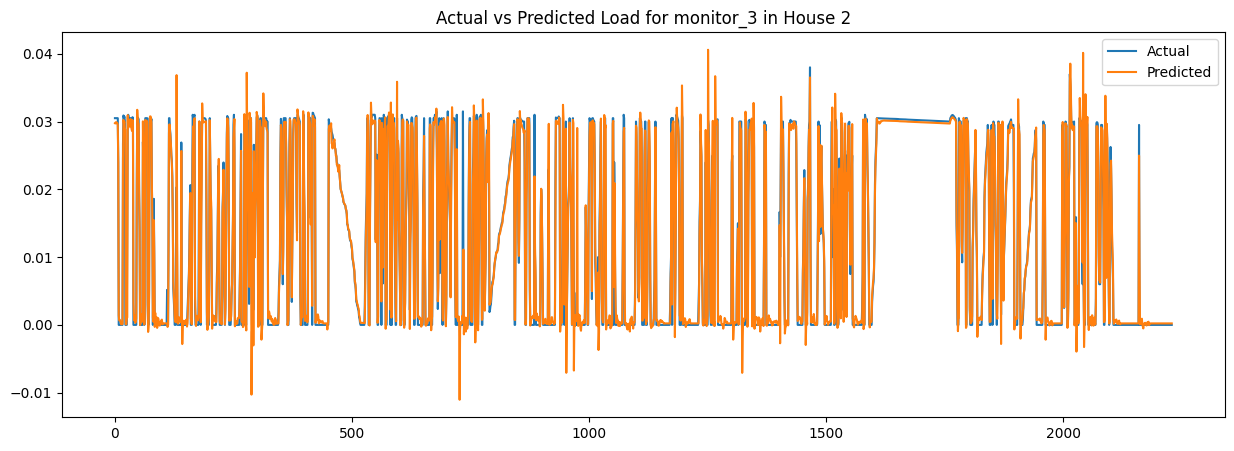

First 5 actual vs predicted values for monitor_3 in House 2:
Actual: 0.0305, Predicted: 0.029767598992153865
Actual: 0.0305, Predicted: 0.029846675678867486
Actual: 0.0305, Predicted: 0.029732752557738804
Actual: 0.0305, Predicted: 0.029914792137891697
Actual: 0.0305, Predicted: 0.029771979900789062
Predicting consumption for fridge_14 in House 2...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
fridge_14 - Best Params: {'fit_intercept': False}
fridge_14 - CV MSE: 2.508055231542454e-05, CV MAE: 0.002118062770678734, CV R²: 0.9064499522101535


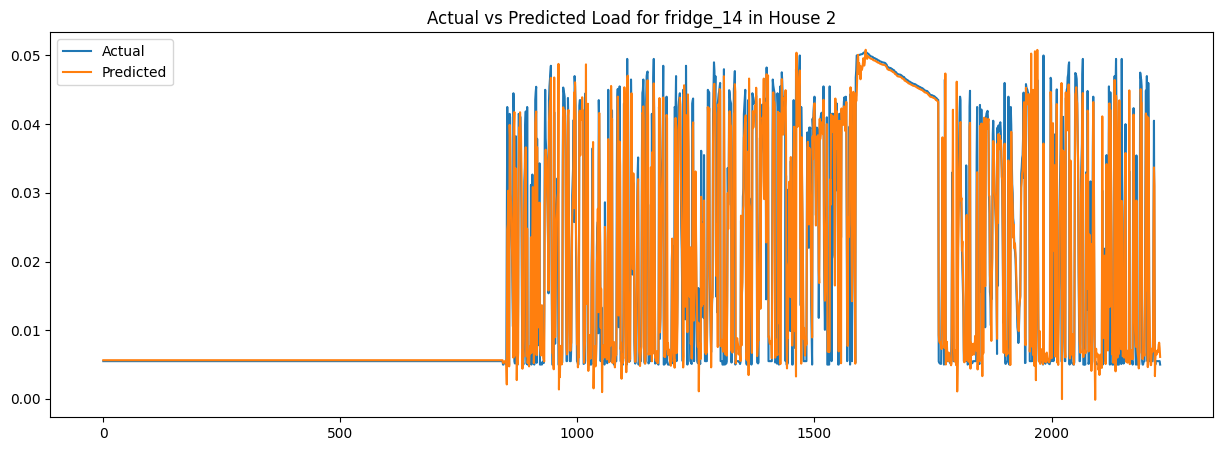

First 5 actual vs predicted values for fridge_14 in House 2:
Actual: 0.0055, Predicted: 0.00563638270039825
Actual: 0.0055, Predicted: 0.00563638270039825
Actual: 0.0055, Predicted: 0.00563638270039825
Actual: 0.0055, Predicted: 0.00563638270039825
Actual: 0.0055, Predicted: 0.00563638270039825
Predicting consumption for microwave_15 in House 2...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
microwave_15 - Best Params: {'fit_intercept': False}
microwave_15 - CV MSE: 0.00021415590791391852, CV MAE: 0.001219397257241536, CV R²: 0.8431361406052836


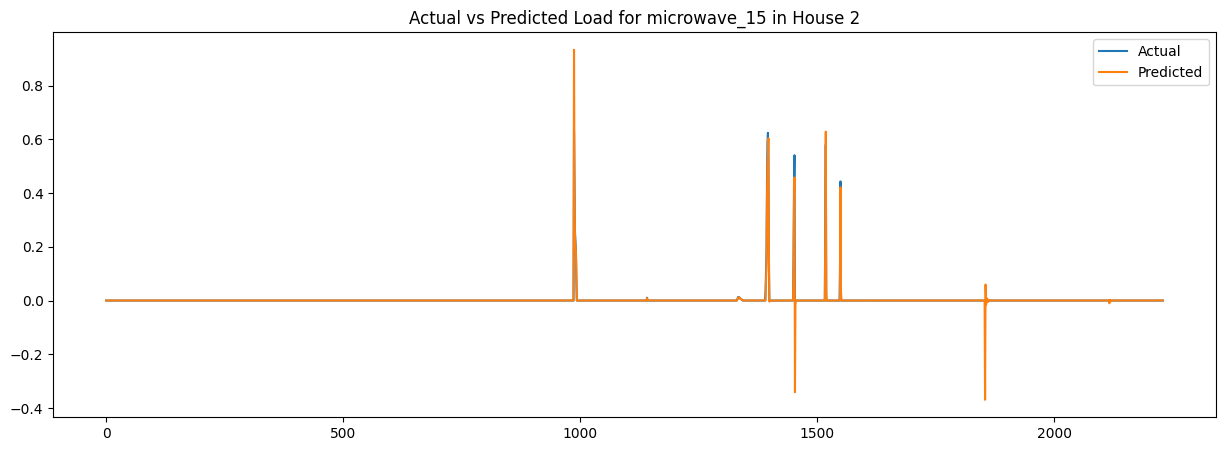

First 5 actual vs predicted values for microwave_15 in House 2:
Actual: 0.0, Predicted: 0.00032410897531653157
Actual: 0.0, Predicted: 0.00032410897531653157
Actual: 0.0, Predicted: 0.00032410897531653157
Actual: 0.0, Predicted: 0.00032410897531653157
Actual: 0.0, Predicted: 0.00032410897531653157
Predicting consumption for kettle_8 in House 2...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
kettle_8 - Best Params: {'fit_intercept': False}
kettle_8 - CV MSE: 0.0013044172499237033, CV MAE: 0.00387344716797382, CV R²: 0.8433590403659588


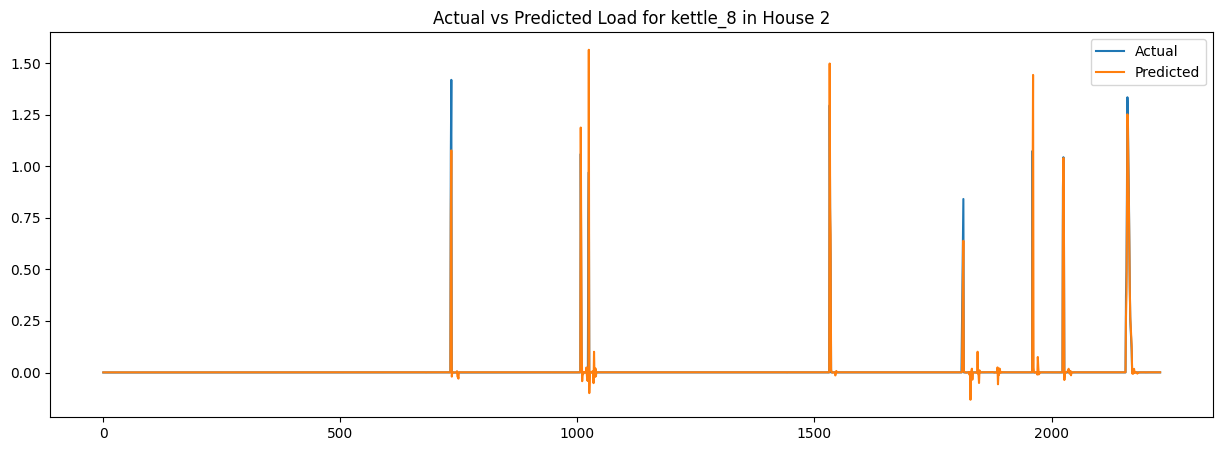

First 5 actual vs predicted values for kettle_8 in House 2:
Actual: 0.0, Predicted: 0.0006780714112677808
Actual: 0.0, Predicted: 0.0006780714112677808
Actual: 0.0, Predicted: 0.0006780714112677808
Actual: 0.0, Predicted: 0.0006780714112677808
Actual: 0.0, Predicted: 0.0006780714112677808


In [ ]:
# Preprocess data for Linear Regression with timestamps
def preprocess_data(df, seq_length=50):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    timestamps = df.index.to_numpy()
    sequences = create_sequences(scaled_data, timestamps, seq_length)
    X, y, seq_timestamps = zip(*sequences)
    X = np.array(X)
    y = np.array(y)
    seq_timestamps = np.array(seq_timestamps)
    return X, y, seq_timestamps, scaler

# Specify the target house
target_house = 2  # Change this to the desired house number

# Train and evaluate for the target house
house_data = df[target_house]
appliances = key_appliances_per_house[target_house]

results = {}

# Define parameter grid for GridSearchCV
param_grid = {
    'fit_intercept': [True, False]
}

# Add cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for appliance in appliances:
    if appliance in house_data.columns:
        print(f"Predicting consumption for {appliance} in House {target_house}...")

        # Use the selected appliance's power consumption for forecasting
        df_load = house_data[[appliance]]

        # Preprocess data
        seq_length = 96  # 48 hours in 30-minute intervals
        X, y, seq_timestamps, scaler = preprocess_data(df_load, seq_length)

        # Flatten the sequences for Linear Regression
        X_flattened = X.reshape(X.shape[0], -1)

        # Initialize the model
        lr = LinearRegression()

        # GridSearchCV
        grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
        grid_search.fit(X_flattened, y)

        best_model = grid_search.best_estimator_

        # Cross-validation metrics
        cv_mse, cv_mae, cv_r2 = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Flatten the sequences for Linear Regression
            X_train_flattened = X_train.reshape(X_train.shape[0], -1)
            X_test_flattened = X_test.reshape(X_test.shape[0], -1)

            # Train the best model
            best_model.fit(X_train_flattened, y_train)

            # Make predictions
            y_pred = best_model.predict(X_test_flattened)

            # Inverse transform predictions
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

            # Evaluation metrics
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            r2 = r2_score(y_test_inv, y_pred_inv)

            cv_mse.append(mse)
            cv_mae.append(mae)
            cv_r2.append(r2)

        print(f'{appliance} - Best Params: {grid_search.best_params_}')
        print(f'{appliance} - CV MSE: {np.mean(cv_mse)}, CV MAE: {np.mean(cv_mae)}, CV R²: {np.mean(cv_r2)}')

        # Plot actual vs predicted values
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(y_pred_inv, label='Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted Load for {appliance} in House {target_house}')
        plt.show()

        # Print 5 actual vs predicted values
        print(f"First 5 actual vs predicted values for {appliance} in House {target_house}:")
        for i in range(5):
            print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

        # Store results
        results[f'House {target_house} - {appliance}'] = {
            'best_params': grid_search.best_params_,
            'cv_mse': np.mean(cv_mse),
            'cv_mae': np.mean(cv_mae),
            'cv_r2': np.mean(cv_r2)
        }

###Model Evaluation of Linear Regression

In [ ]:
# Print summary of results
for key, metrics in results.items():
    print(f"{key} - MSE: {metrics['cv_mse']}, MAE: {metrics['cv_mae']}, R²: {metrics['cv_r2']}")

House 2 - aggregate_1 - MSE: 0.0043683531512560565, MAE: 0.018557103838921573, R²: 0.9039223987287045
House 2 - washing_machine_12 - MSE: 8.191197095411613e-06, MAE: 0.00024353367691627367, R²: 0.9615926684253685
House 2 - monitor_3 - MSE: 5.356603640325662e-06, MAE: 0.0010175353923063185, R²: 0.9691041537265919
House 2 - fridge_14 - MSE: 2.508055231542454e-05, MAE: 0.002118062770678734, R²: 0.9064499522101535
House 2 - microwave_15 - MSE: 0.00021415590791391852, MAE: 0.001219397257241536, R²: 0.8431361406052836
House 2 - kettle_8 - MSE: 0.0013044172499237033, MAE: 0.00387344716797382, R²: 0.8433590403659588


## Gated Recurrent Unit (GRU)

Predicting consumption for aggregate_1 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.1871
Epoch 2/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0977
Epoch 3/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0972
Epoch 4/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0869
Epoch 5/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0825
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0802
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0847
Epoch 8/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0811
Epoch 9/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0792
Epoch 10/10
70/70 [==============================] - 1s 4ms/step
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.1915
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss

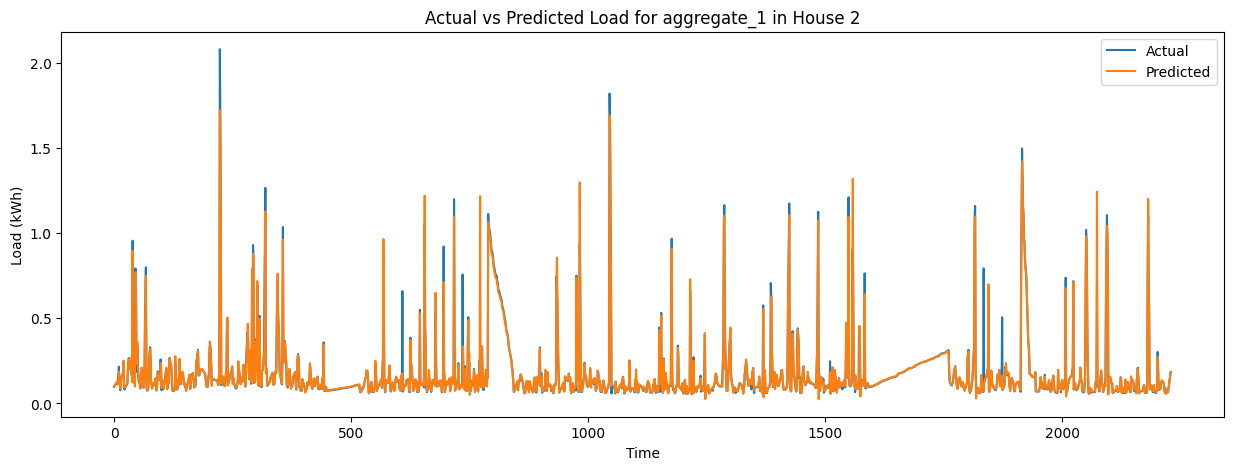

First 5 actual vs predicted values for aggregate_1 in House 2:
Actual: 0.098, Predicted: 0.10013256967067719
Actual: 0.1035, Predicted: 0.10554462671279907
Actual: 0.10533333333333333, Predicted: 0.10735104233026505
Actual: 0.11266666666666665, Predicted: 0.11456742137670517
Actual: 0.11633333333333333, Predicted: 0.11817537248134613
Predicting consumption for washing_machine_12 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.0745
Epoch 2/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0340
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0330
Epoch 4/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0301
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0304
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0253
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0281
Epoch 8/10
140/140 [=================

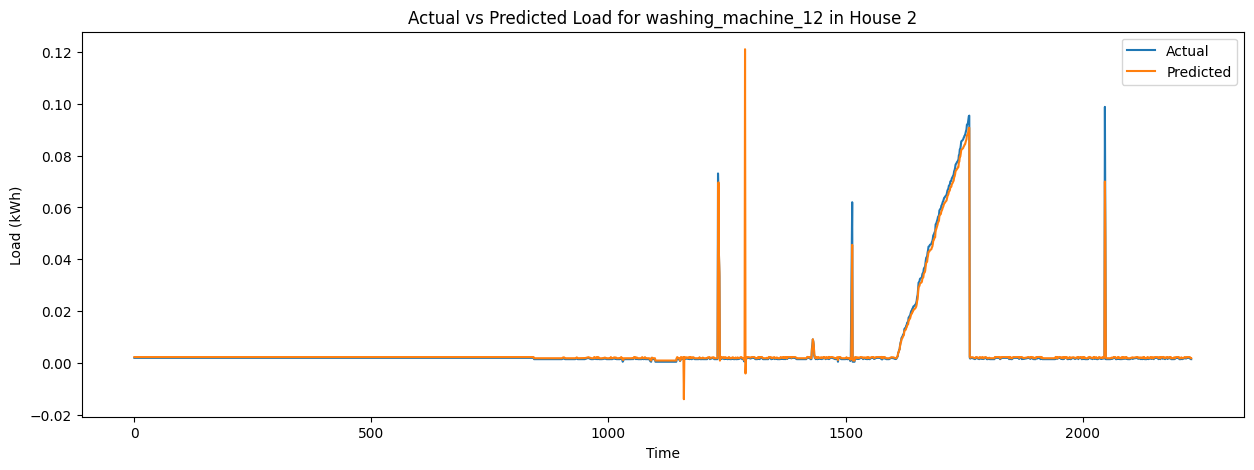

First 5 actual vs predicted values for washing_machine_12 in House 2:
Actual: 0.002, Predicted: 0.002306354930624366
Actual: 0.002, Predicted: 0.002306354930624366
Actual: 0.002, Predicted: 0.002306354930624366
Actual: 0.002, Predicted: 0.002306354930624366
Actual: 0.002, Predicted: 0.002306354930624366
Predicting consumption for monitor_3 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.1372
Epoch 2/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0548
Epoch 3/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0459
Epoch 4/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0428
Epoch 5/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0413
Epoch 6/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0410
Epoch 7/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0399
Epoch 8/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0

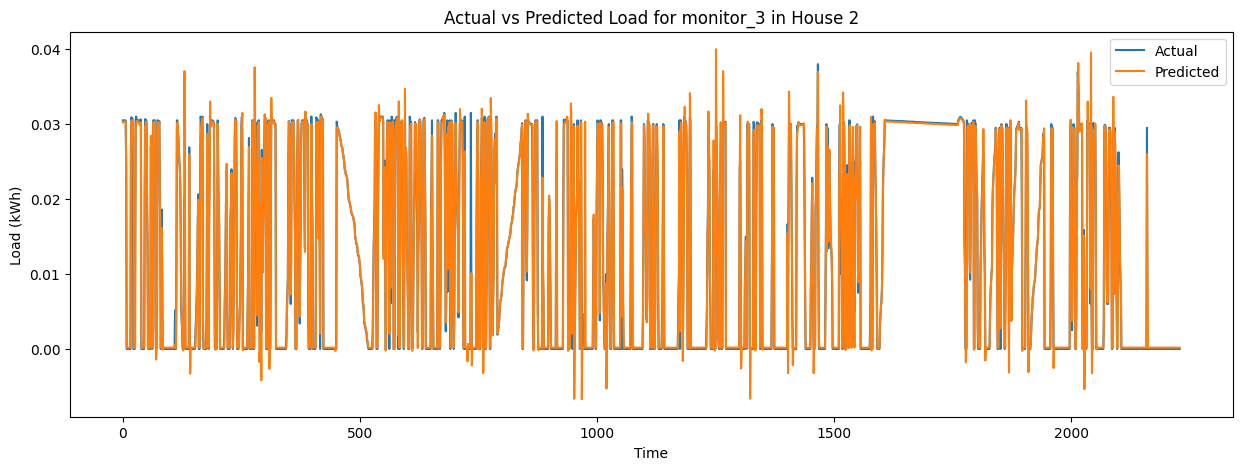

First 5 actual vs predicted values for monitor_3 in House 2:
Actual: 0.0305, Predicted: 0.030210278928279877
Actual: 0.0305, Predicted: 0.03029511496424675
Actual: 0.0305, Predicted: 0.030312305316329002
Actual: 0.0305, Predicted: 0.030345911160111427
Actual: 0.0305, Predicted: 0.03035270981490612
Predicting consumption for fridge_14 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.2078
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1151
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1091
Epoch 4/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1073
Epoch 5/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1042
Epoch 6/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1022
Epoch 7/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1009
Epoch 8/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1011
Ep

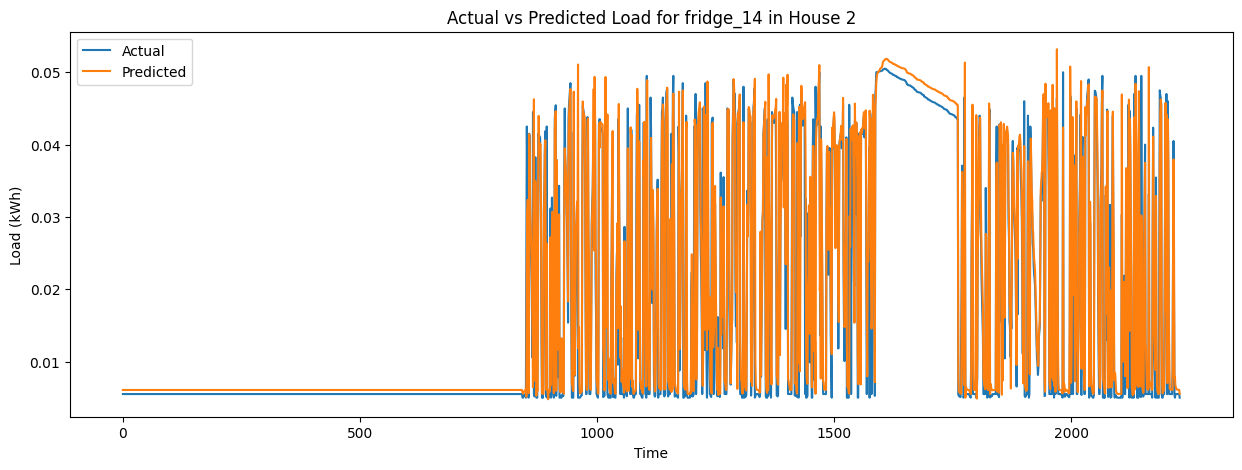

First 5 actual vs predicted values for fridge_14 in House 2:
Actual: 0.0055, Predicted: 0.006064371205866337
Actual: 0.0055, Predicted: 0.006064371205866337
Actual: 0.0055, Predicted: 0.006064371205866337
Actual: 0.0055, Predicted: 0.006064371205866337
Actual: 0.0055, Predicted: 0.006064371205866337
Predicting consumption for microwave_15 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.4036
Epoch 2/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1899
Epoch 3/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1332
Epoch 4/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1155
Epoch 5/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1158
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1170
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1191
Epoch 8/10
140/140 [==============================] - 1s 9ms/step - loss: 0.10

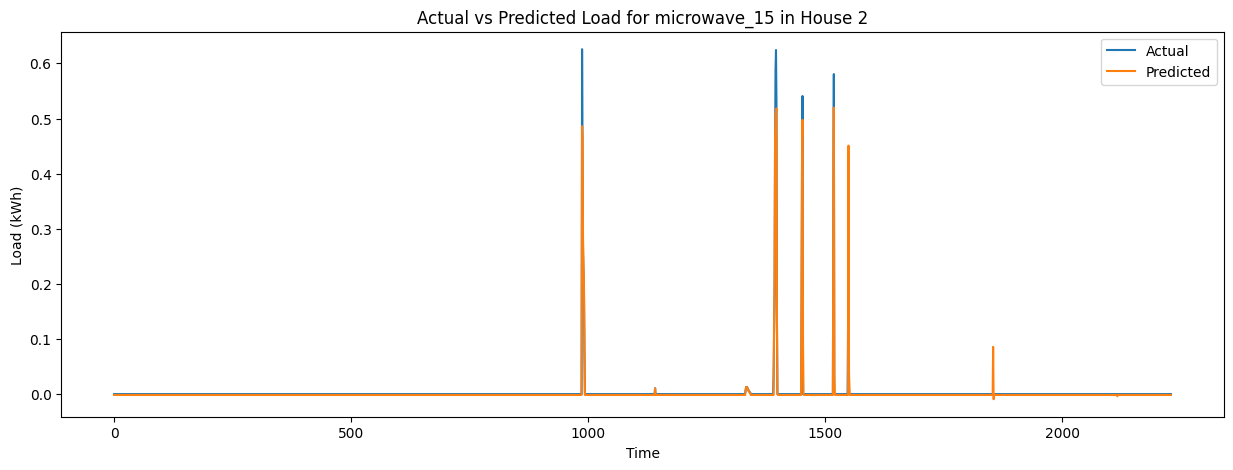

First 5 actual vs predicted values for microwave_15 in House 2:
Actual: 0.0, Predicted: -0.0015932052629068494
Actual: 0.0, Predicted: -0.0015932052629068494
Actual: 0.0, Predicted: -0.0015932052629068494
Actual: 0.0, Predicted: -0.0015932052629068494
Actual: 0.0, Predicted: -0.0015932052629068494
Predicting consumption for kettle_8 in House 2...
Epoch 1/10
140/140 [==============================] - 4s 9ms/step - loss: 0.4806
Epoch 2/10
140/140 [==============================] - 1s 8ms/step - loss: 0.2125
Epoch 3/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1518
Epoch 4/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1504
Epoch 5/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1382
Epoch 6/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1400
Epoch 7/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1433
Epoch 8/10
140/140 [==============================] - 1s 8ms/step - loss: 0.1357
Epo

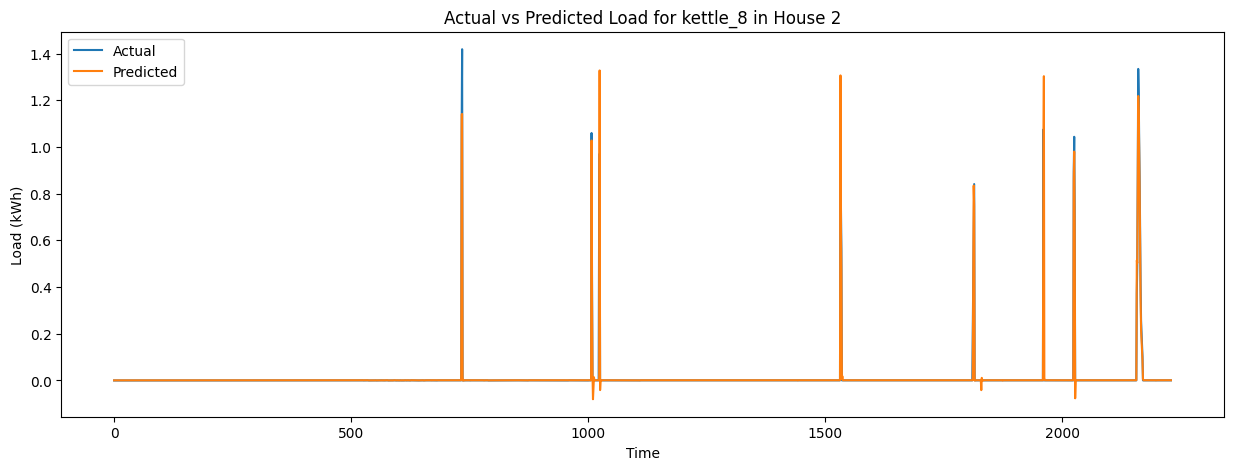

First 5 actual vs predicted values for kettle_8 in House 2:
Actual: 0.0, Predicted: 0.0005586934275925159
Actual: 0.0, Predicted: 0.0005586934275925159
Actual: 0.0, Predicted: 0.0005586934275925159
Actual: 0.0, Predicted: 0.0005586934275925159
Actual: 0.0, Predicted: 0.0005586934275925159


In [ ]:
# Specify the target house
target_house = 2  # Change this to the desired house number

# Train and evaluate for the target house
house_data = df[target_house]
appliances = key_appliances_per_house[target_house]

results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for appliance in appliances:
    if appliance in house_data.columns:
        print(f"Predicting consumption for {appliance} in House {target_house}...")

        # Use the selected appliance's power consumption for forecasting
        df_load = house_data[[appliance]]

        # Preprocess data
        seq_length = 96  # 48 hours in 30-minute intervals
        X, y, seq_timestamps, scaler = preprocess_data(df_load, seq_length)

        cv_mse, cv_mae, cv_r2 = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Build and train GRU model
            model = Sequential()
            model.add(GRU(64, return_sequences=True, input_shape=(seq_length, 1)))
            model.add(Dropout(0.2))
            model.add(GRU(64))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
            model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

            # Make predictions
            y_pred = model.predict(X_test)

            # Inverse transform predictions
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)

            # Evaluation metrics
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            r2 = r2_score(y_test_inv, y_pred_inv)

            cv_mse.append(mse)
            cv_mae.append(mae)
            cv_r2.append(r2)

        print(f'{appliance} - CV MSE: {np.mean(cv_mse)}, CV MAE: {np.mean(cv_mae)}, CV R²: {np.mean(cv_r2)}')

        # Plot actual vs predicted values
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(y_pred_inv, label='Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted Load for {appliance} in House {target_house}')
        plt.xlabel('Time')
        plt.ylabel('Load (kWh)')
        plt.show()

        # Print 5 actual vs predicted values
        print(f"First 5 actual vs predicted values for {appliance} in House {target_house}:")
        for i in range(5):
            print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

        # Store results
        results[f'House {target_house} - {appliance}'] = {'cv_mse': np.mean(cv_mse), 'cv_mae': np.mean(cv_mae), 'cv_r2': np.mean(cv_r2)}

### Model Evaluation of GRU

In [ ]:
# Print summary of results
for key, metrics in results.items():
    print(f"{key} - MSE: {metrics['cv_mse']}, MAE: {metrics['cv_mae']}, R²: {metrics['cv_r2']}")

House 2 - aggregate_1 - MSE: 0.003519476563645816, MAE: 0.013710826629367684, R²: 0.9229207018571686
House 2 - washing_machine_12 - MSE: 7.254212874735273e-06, MAE: 0.00045776712514141257, R²: 0.9673366989820288
House 2 - monitor_3 - MSE: 4.852294443083999e-06, MAE: 0.0008567774855504313, R²: 0.9720111131280156
House 2 - fridge_14 - MSE: 2.2844696878395478e-05, MAE: 0.0020013978035815744, R²: 0.9148376464884347
House 2 - microwave_15 - MSE: 0.00013261604630643086, MAE: 0.00128378234565939, R²: 0.9082801204103724
House 2 - kettle_8 - MSE: 0.0009028366900936207, MAE: 0.003437703147705589, R²: 0.8934159227756518


## Bidirectional LSTM

Predicting consumption for aggregate_1 in House 2...
Epoch 1/10
140/140 [==============================] - 9s 27ms/step - loss: 0.2504 - val_loss: 0.1461
Epoch 2/10
140/140 [==============================] - 2s 18ms/step - loss: 0.1272 - val_loss: 0.1394
Epoch 3/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1037 - val_loss: 0.1091
Epoch 4/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0967 - val_loss: 0.1037
Epoch 5/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0954 - val_loss: 0.1044
Epoch 6/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0876 - val_loss: 0.1155
Epoch 7/10
140/140 [==============================] - 3s 19ms/step - loss: 0.0886 - val_loss: 0.1000
Epoch 8/10
140/140 [==============================] - 3s 20ms/step - loss: 0.0814 - val_loss: 0.0988
Epoch 9/10
140/140 [==============================] - 3s 19ms/step - loss: 0.0862 - val_loss: 0.0979
Epoch 10/10
70/70 [===================

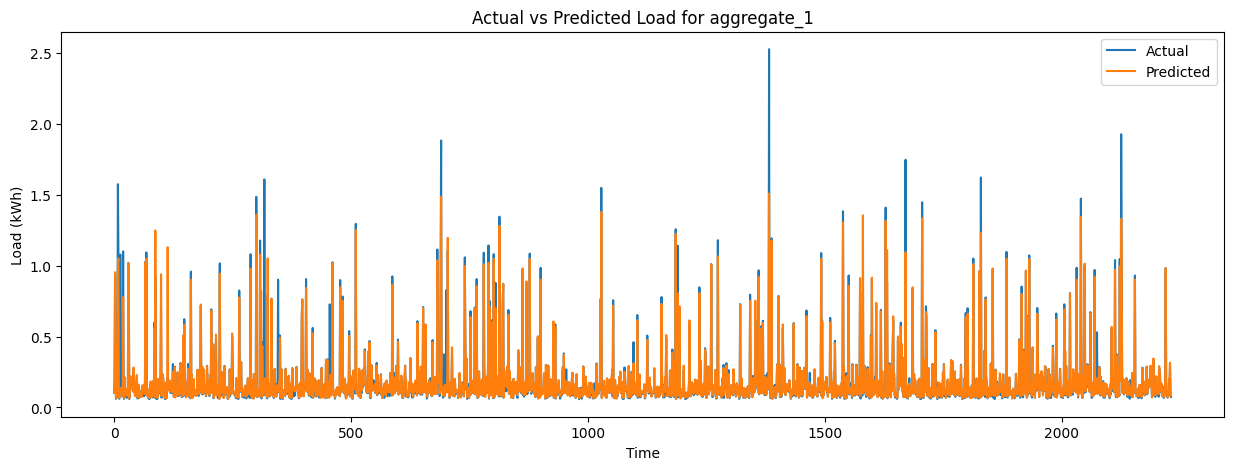

First 5 actual vs predicted values for aggregate_1 in House 2:
Actual: 0.10583333333333333, Predicted: 0.10150199383497238
Actual: 0.1950216400911162, Predicted: 0.19824743270874023
Actual: 0.9386605504587155, Predicted: 0.9536733627319336
Actual: 0.258, Predicted: 0.21876321732997894
Actual: 0.061, Predicted: 0.06662199646234512
Predicting consumption for washing_machine_12 in House 2...
Epoch 1/10
140/140 [==============================] - 9s 28ms/step - loss: 0.0953 - val_loss: 0.1318
Epoch 2/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0441 - val_loss: 0.1133
Epoch 3/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0373 - val_loss: 0.1249
Epoch 4/10
140/140 [==============================] - 3s 19ms/step - loss: 0.0359 - val_loss: 0.0958
Epoch 5/10
140/140 [==============================] - 2s 18ms/step - loss: 0.0325 - val_loss: 0.0860
Epoch 6/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0293 - val_loss: 0.0877
Ep

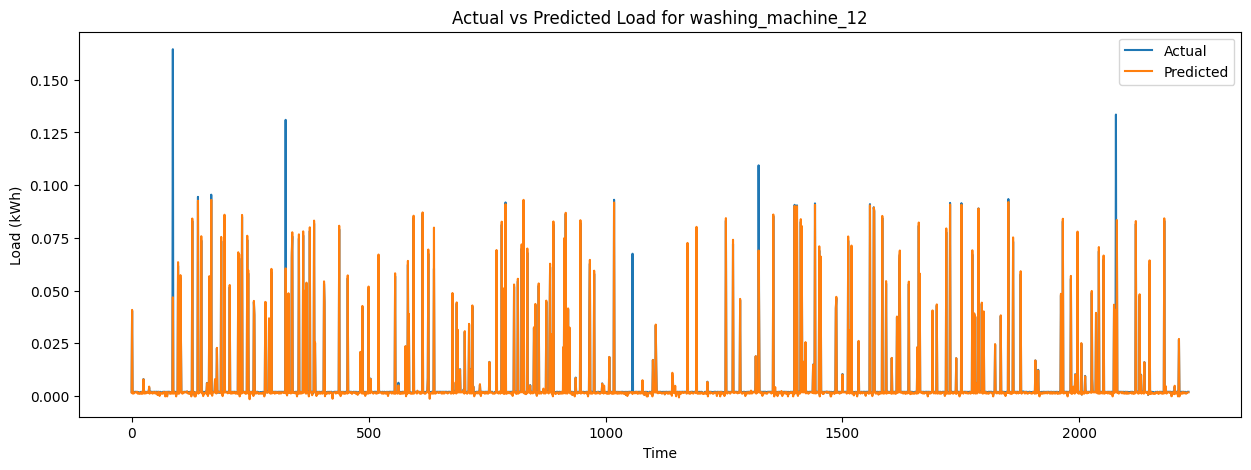

First 5 actual vs predicted values for washing_machine_12 in House 2:
Actual: 0.002, Predicted: 0.0017163639422506094
Actual: 0.0404084249084249, Predicted: 0.04084722325205803
Actual: 0.0015, Predicted: 0.0011943844147026539
Actual: 0.002, Predicted: 0.0017571346834301949
Actual: 0.001666666666666667, Predicted: 0.0011756480671465397
Predicting consumption for monitor_3 in House 2...
Epoch 1/10
140/140 [==============================] - 9s 28ms/step - loss: 0.1475 - val_loss: 0.0617
Epoch 2/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0649 - val_loss: 0.0438
Epoch 3/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0563 - val_loss: 0.0424
Epoch 4/10
140/140 [==============================] - 3s 19ms/step - loss: 0.0513 - val_loss: 0.0374
Epoch 5/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0473 - val_loss: 0.0309
Epoch 6/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0439 - val_loss: 0.0314
Epoch 

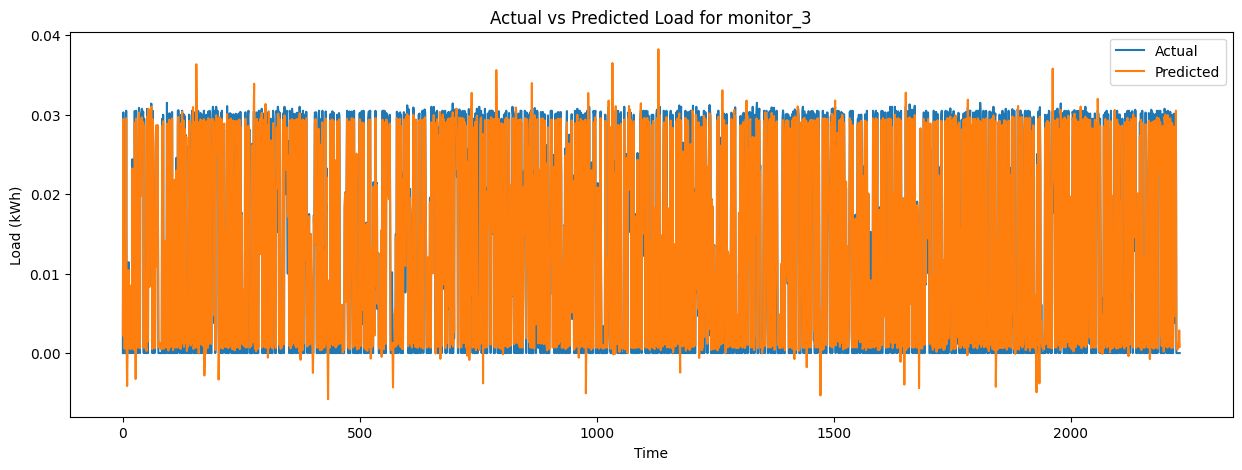

First 5 actual vs predicted values for monitor_3 in House 2:
Actual: 0.0, Predicted: 0.002221841597929597
Actual: 0.030293040293040294, Predicted: 0.029478980228304863
Actual: 0.007230392156862746, Predicted: 0.007827801629900932
Actual: 0.0, Predicted: 0.000695378752425313
Actual: 0.0, Predicted: 0.0005382050294429064
Predicting consumption for fridge_14 in House 2...
Epoch 1/10
140/140 [==============================] - 10s 29ms/step - loss: 0.2223 - val_loss: 0.1172
Epoch 2/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1249 - val_loss: 0.0933
Epoch 3/10
140/140 [==============================] - 3s 18ms/step - loss: 0.1163 - val_loss: 0.0849
Epoch 4/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1118 - val_loss: 0.0799
Epoch 5/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1064 - val_loss: 0.0793
Epoch 6/10
140/140 [==============================] - 3s 18ms/step - loss: 0.1058 - val_loss: 0.0752
Epoch 7/10
140/140 [=

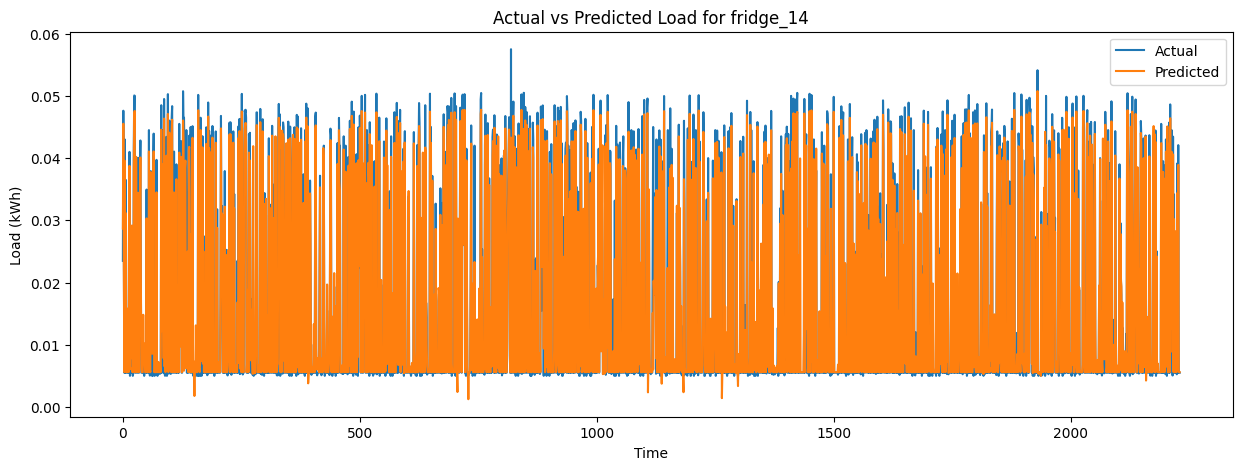

First 5 actual vs predicted values for fridge_14 in House 2:
Actual: 0.0235, Predicted: 0.028687145560979843
Actual: 0.04761463414634146, Predicted: 0.045523688197135925
Actual: 0.025321428571428575, Predicted: 0.022861024364829063
Actual: 0.0055, Predicted: 0.005591937340795994
Actual: 0.043, Predicted: 0.039563797414302826
Predicting consumption for microwave_15 in House 2...
Epoch 1/10
140/140 [==============================] - 10s 28ms/step - loss: 0.5005 - val_loss: 0.2020
Epoch 2/10
140/140 [==============================] - 3s 18ms/step - loss: 0.2396 - val_loss: 0.1506
Epoch 3/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1794 - val_loss: 0.1241
Epoch 4/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1631 - val_loss: 0.1247
Epoch 5/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1254 - val_loss: 0.1246
Epoch 6/10
140/140 [==============================] - 3s 18ms/step - loss: 0.1230 - val_loss: 0.1268
Epoch 7/10
1

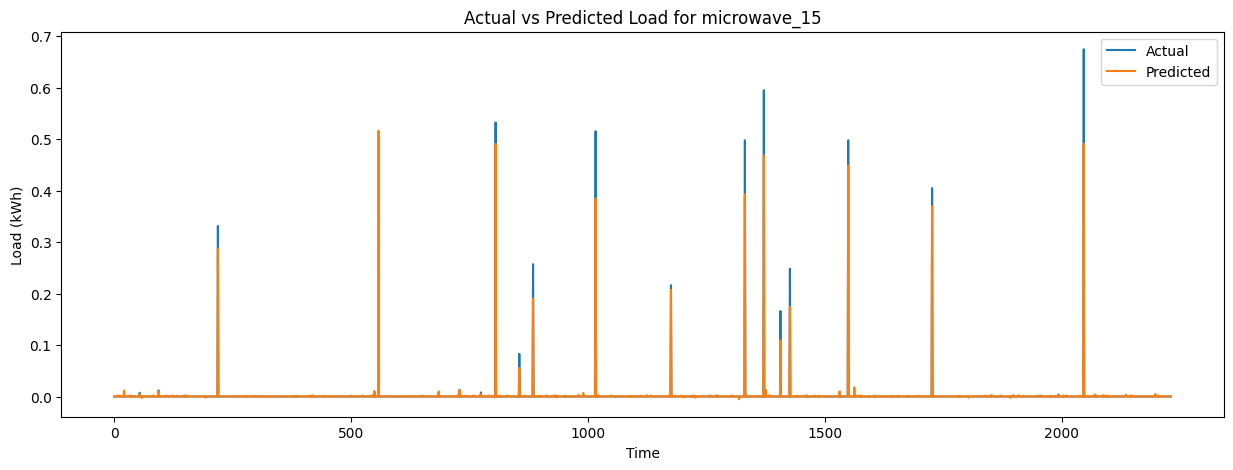

First 5 actual vs predicted values for microwave_15 in House 2:
Actual: 0.0, Predicted: 0.00010167610162170604
Actual: 0.0, Predicted: 0.00010167610162170604
Actual: 0.0, Predicted: 0.00010167610162170604
Actual: 0.0, Predicted: 0.00010167610162170604
Actual: 0.0, Predicted: 0.00010167610162170604
Predicting consumption for kettle_8 in House 2...
Epoch 1/10
140/140 [==============================] - 9s 28ms/step - loss: 0.4970 - val_loss: 0.1350
Epoch 2/10
140/140 [==============================] - 3s 18ms/step - loss: 0.2296 - val_loss: 0.0835
Epoch 3/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1758 - val_loss: 0.0589
Epoch 4/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1572 - val_loss: 0.0442
Epoch 5/10
140/140 [==============================] - 3s 19ms/step - loss: 0.1502 - val_loss: 0.0339
Epoch 6/10
140/140 [==============================] - 3s 18ms/step - loss: 0.1395 - val_loss: 0.0297
Epoch 7/10
140/140 [=========================

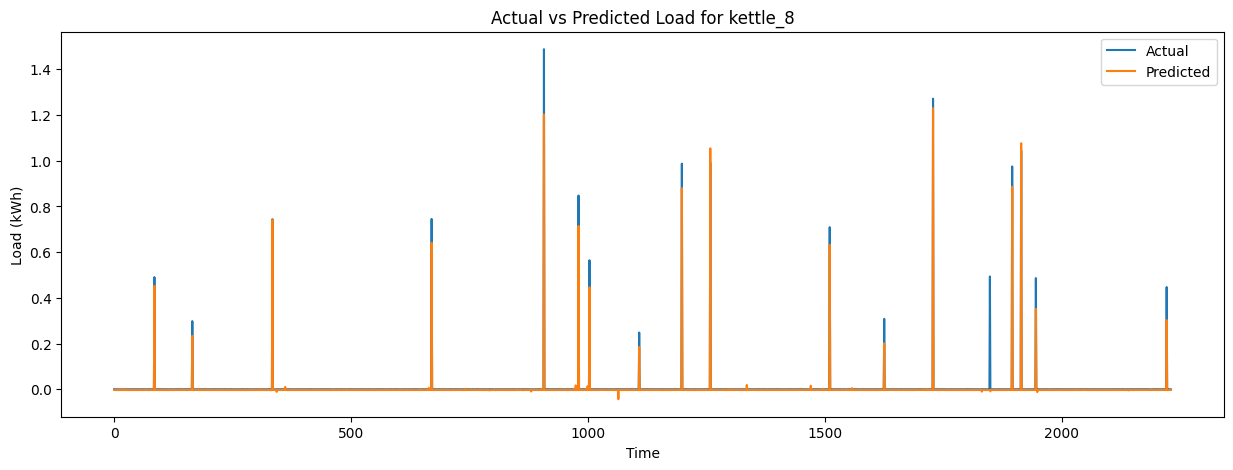

First 5 actual vs predicted values for kettle_8 in House 2:
Actual: 0.0007499999999999998, Predicted: -0.0026075933128595352
Actual: 0.0004999999999999996, Predicted: -0.002967407926917076
Actual: 0.0004999999999999996, Predicted: -0.002967407926917076
Actual: 0.0, Predicted: -0.002809152938425541
Actual: 0.0004999999999999996, Predicted: -0.0029643820598721504


In [ ]:
# Specify the target house
target_house = 2  # Change this to the desired house number

# Train and evaluate for the target house
house_data = df[target_house]
appliances = key_appliances_per_house[target_house]

results = {}

for appliance in appliances:
    if appliance in house_data.columns:
        print(f"Predicting consumption for {appliance} in House {target_house}...")

        # Use the selected appliance's power consumption for forecasting
        df_load = house_data[[appliance]]

        # Preprocess data
        seq_length = 96  # 48 hours in 30-minute intervals
        X, y, seq_timestamps, scaler = preprocess_data(df_load, seq_length)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Build and train Bidirectional LSTM model
        model = Sequential()
        model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(seq_length, 1)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

        # Make predictions
        y_pred = model.predict(X_test)

        # Inverse transform predictions
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler.inverse_transform(y_pred)

        # Evaluation metrics
        mse = mean_squared_error(y_test_inv, y_pred_inv)
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        r2 = r2_score(y_test_inv, y_pred_inv)

        print(f'{appliance} - MSE: {mse}, MAE: {mae}, R²: {r2}')
        results[appliance] = {'mse': mse, 'mae': mae, 'r2': r2}

        # Plot actual vs predicted values
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(y_pred_inv, label='Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted Load for {appliance}')
        plt.xlabel('Time')
        plt.ylabel('Load (kWh)')
        plt.show()

        # Print 5 actual vs predicted values
        print(f"First 5 actual vs predicted values for {appliance} in House {target_house}:")
        for i in range(5):
            print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

### Model Evaluation of Bidirectional LSTM

In [ ]:
# Print results summary
for appliance, metrics in results.items():
    print(f"House {target_house}: {appliance} - MSE: {metrics['mse']}, MAE: {metrics['mae']}, R²: {metrics['r2']}")

House 2: aggregate_1 - MSE: 0.004405846826921651, MAE: 0.01580451561107692, R²: 0.9064208460098166
House 2: washing_machine_12 - MSE: 1.5691672924152374e-05, MAE: 0.0005657388343282846, R²: 0.9418811102523071
House 2: monitor_3 - MSE: 4.2661824558639485e-06, MAE: 0.0011830867111088856, R²: 0.9756169221391647
House 2: fridge_14 - MSE: 1.7994925283588028e-05, MAE: 0.0019816976018013216, R²: 0.9335083317965428
House 2: microwave_15 - MSE: 0.00016442578279276954, MAE: 0.0008982024500041109, R²: 0.8422051875033686
House 2: kettle_8 - MSE: 0.00021965899147868406, MAE: 0.004211979225940545, R²: 0.9576159645190733


## Model Implementation with Contextual features

#### Pre-processing Time Series Data with Contextual Features

In [ ]:
# Function to create sequences with timestamps
def create_sequences(data, timestamps, contextual_features, seq_length):
    sequences = []
    labels = []
    context = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        seq_context = contextual_features[i:i + seq_length]
        sequences.append(seq)
        labels.append(label)
        context.append(seq_context)
    return np.array(sequences), np.array(labels), np.array(context)

In [ ]:
# Preprocess data for LSTM with contextual features
def preprocess_data(df, seq_length=50):
    # Generate time-based contextual features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    contextual_features = df[['hour', 'day_of_week', 'month', 'is_weekend']].values

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.drop(columns=['hour', 'day_of_week', 'month', 'is_weekend']))
    timestamps = df.index.to_numpy()

    sequences, labels, context = create_sequences(scaled_data, timestamps, contextual_features, seq_length)
    return sequences, labels, context, scaler

## LSTM with Contextual features

Predicting consumption for aggregate_1 in House 2...
Epoch 1/20
140/140 [==============================] - 26s 76ms/step - loss: 0.2376 - val_loss: 0.1305 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 7s 49ms/step - loss: 0.1109 - val_loss: 0.1226 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0935 - val_loss: 0.0913 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 7s 49ms/step - loss: 0.0915 - val_loss: 0.0959 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0893 - val_loss: 0.0965 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0818 - val_loss: 0.1022 - lr: 0.0010
Epoch 7/20
140/140 [==============================] - 7s 47ms/step - loss: 0.0809 - val_loss: 0.0898 - lr: 5.0000e-04
Epoch 8/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0800 - val_loss: 0.0957 - lr: 5.0000e-04
Epoch 9/20
140/140 [======

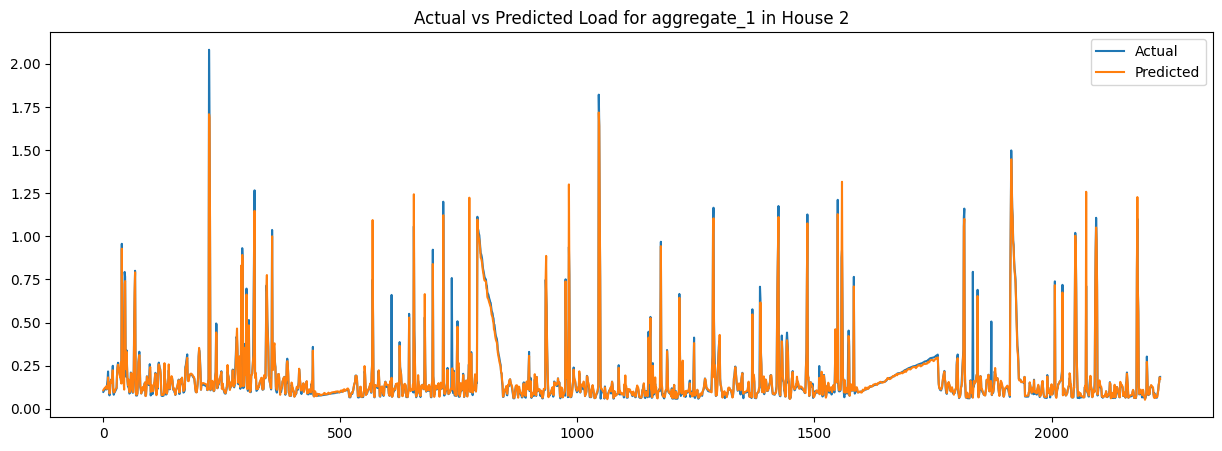

First 5 actual vs predicted values for aggregate_1 in House 2:
Actual: 0.098, Predicted: 0.10756170749664307
Actual: 0.1035, Predicted: 0.11271875351667404
Actual: 0.10533333333333333, Predicted: 0.11440246552228928
Actual: 0.11266666666666665, Predicted: 0.12036944180727005
Actual: 0.11633333333333333, Predicted: 0.12277500331401825
Predicting consumption for washing_machine_12 in House 2...
Epoch 1/20
140/140 [==============================] - 26s 75ms/step - loss: 0.1042 - val_loss: 0.1349 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0488 - val_loss: 0.1429 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 7s 49ms/step - loss: 0.0415 - val_loss: 0.0941 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0338 - val_loss: 0.0993 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0314 - val_loss: 0.0695 - lr: 0.0010
Epoch 6/20
140/140 [=============

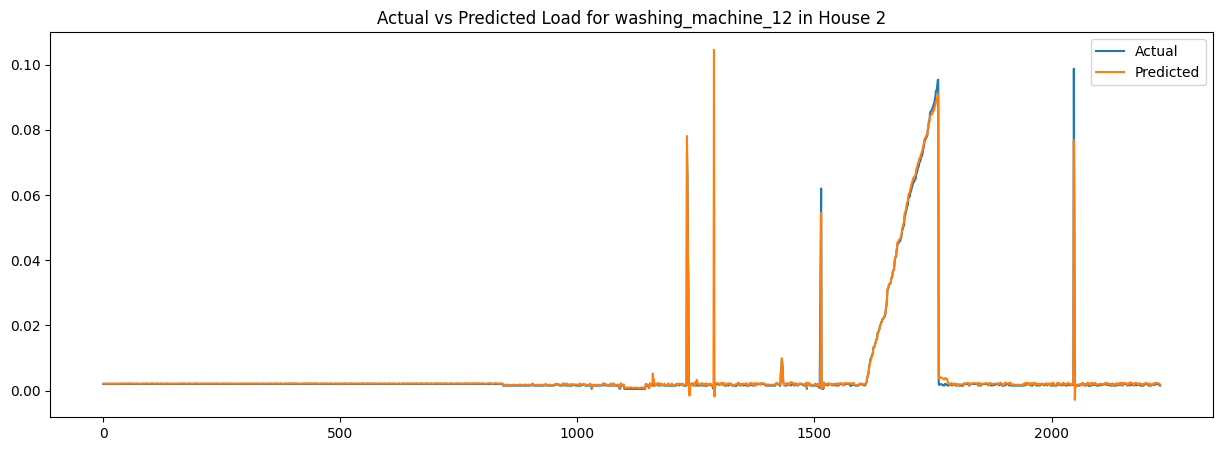

First 5 actual vs predicted values for washing_machine_12 in House 2:
Actual: 0.002, Predicted: 0.002122424775734544
Actual: 0.002, Predicted: 0.002118446631357074
Actual: 0.002, Predicted: 0.0021168976090848446
Actual: 0.002, Predicted: 0.0021076498087495565
Actual: 0.002, Predicted: 0.002102461876347661
Predicting consumption for monitor_3 in House 2...
Epoch 1/20
140/140 [==============================] - 26s 75ms/step - loss: 0.1380 - val_loss: 0.0636 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0597 - val_loss: 0.0438 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0485 - val_loss: 0.0326 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0423 - val_loss: 0.0263 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0392 - val_loss: 0.0239 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 7s 48ms/step - lo

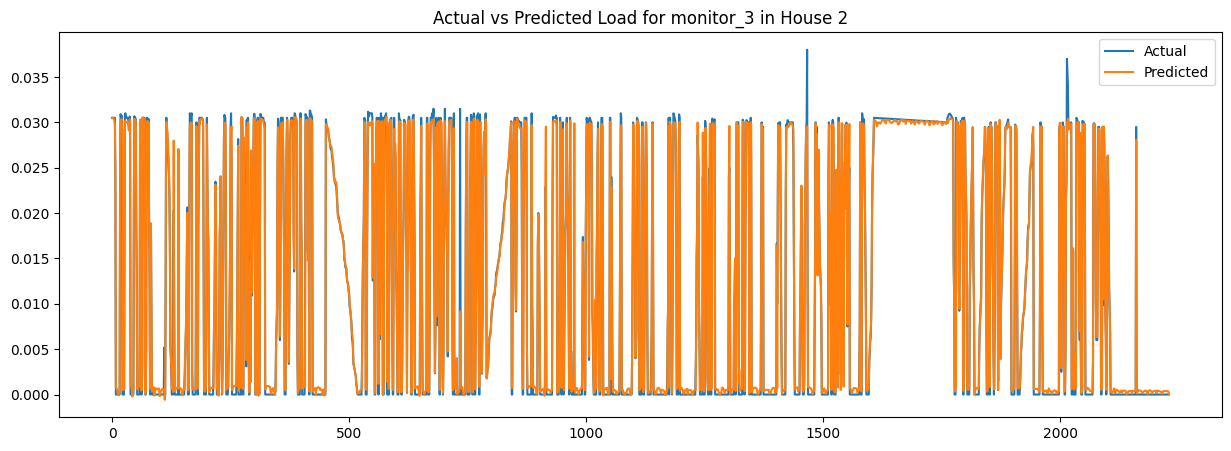

First 5 actual vs predicted values for monitor_3 in House 2:
Actual: 0.0305, Predicted: 0.030479129403829575
Actual: 0.0305, Predicted: 0.030515311285853386
Actual: 0.0305, Predicted: 0.030516479164361954
Actual: 0.0305, Predicted: 0.03044440597295761
Actual: 0.0305, Predicted: 0.030346648767590523
Predicting consumption for fridge_14 in House 2...
Epoch 1/20
140/140 [==============================] - 26s 75ms/step - loss: 0.2170 - val_loss: 0.1057 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 7s 48ms/step - loss: 0.1279 - val_loss: 0.0947 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 7s 48ms/step - loss: 0.1157 - val_loss: 0.0783 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 7s 49ms/step - loss: 0.1089 - val_loss: 0.0711 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 7s 48ms/step - loss: 0.0995 - val_loss: 0.0610 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 7s 49ms/step - loss: 0.0

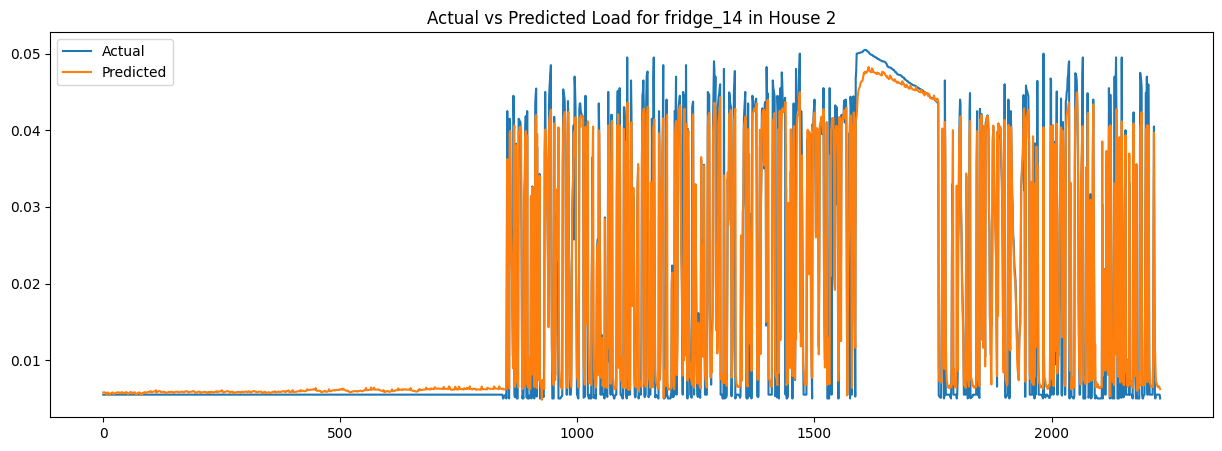

First 5 actual vs predicted values for fridge_14 in House 2:
Actual: 0.0055, Predicted: 0.0057867830619215965
Actual: 0.0055, Predicted: 0.005795331671833992
Actual: 0.0055, Predicted: 0.005797182209789753
Actual: 0.0055, Predicted: 0.005795905366539955
Actual: 0.0055, Predicted: 0.005784953944385052
Predicting consumption for microwave_15 in House 2...
Epoch 1/20
140/140 [==============================] - 26s 75ms/step - loss: 0.4448 - val_loss: 0.1687 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 7s 49ms/step - loss: 0.1815 - val_loss: 0.1277 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 7s 48ms/step - loss: 0.1621 - val_loss: 0.5074 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 7s 49ms/step - loss: 0.1986 - val_loss: 0.1341 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 7s 48ms/step - loss: 0.1379 - val_loss: 0.1225 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 7s 48ms/step - loss

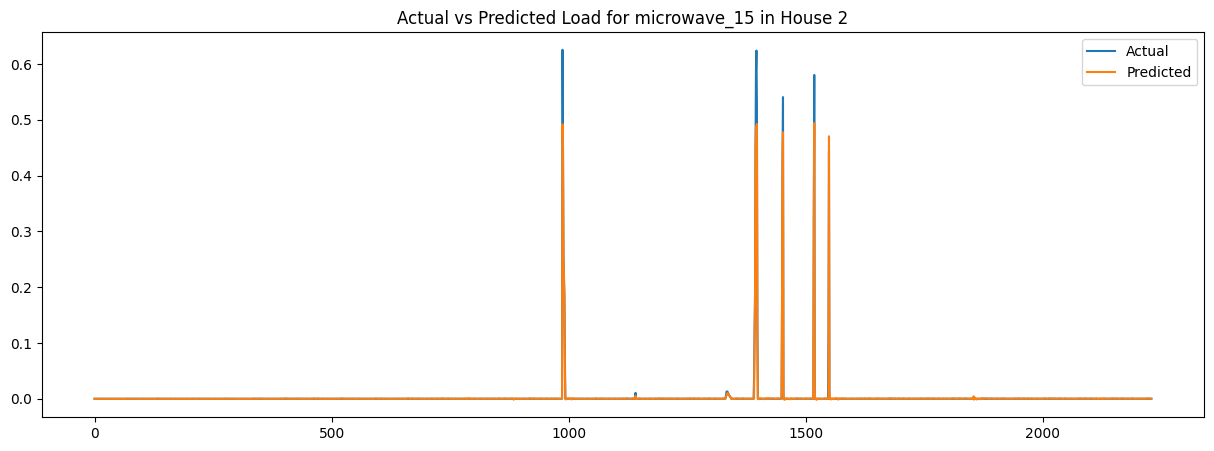

First 5 actual vs predicted values for microwave_15 in House 2:
Actual: 0.0, Predicted: -0.0002877969527617097
Actual: 0.0, Predicted: -0.0002816590713337064
Actual: 0.0, Predicted: -0.0002796401968225837
Actual: 0.0, Predicted: -0.00026075553614646196
Actual: 0.0, Predicted: -0.00023991648049559444
Predicting consumption for kettle_8 in House 2...
Epoch 1/20
140/140 [==============================] - 26s 76ms/step - loss: 0.4358 - val_loss: 0.1166 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 7s 49ms/step - loss: 0.2358 - val_loss: 0.0715 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 7s 49ms/step - loss: 0.1880 - val_loss: 0.0668 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 7s 49ms/step - loss: 0.1645 - val_loss: 0.0608 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 7s 48ms/step - loss: 0.1765 - val_loss: 0.0384 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 7s 49ms/step - loss: 0.1

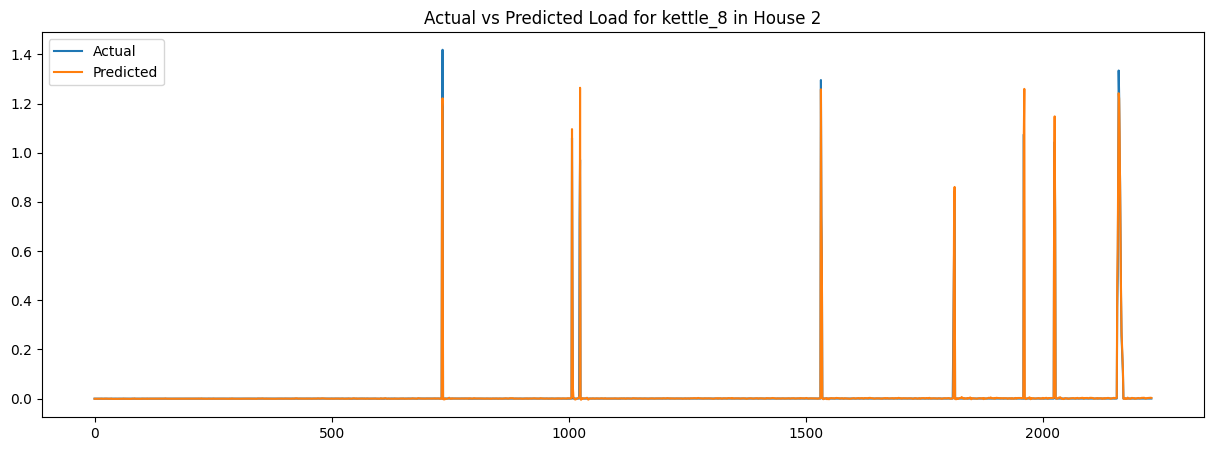

First 5 actual vs predicted values for kettle_8 in House 2:
Actual: 0.0, Predicted: -0.0004573799669742584
Actual: 0.0, Predicted: -0.0004696231335401535
Actual: 0.0, Predicted: -0.0004892386496067047
Actual: 0.0, Predicted: -0.0005827015265822411
Actual: 0.0, Predicted: -0.0006702234968543053


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Specify the target house
target_house = 2  # Change this to the desired house number

# Train and evaluate for the target house
house_data = df[target_house]
appliances = key_appliances_per_house[target_house]

results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for appliance in appliances:
    if appliance in house_data.columns:
        print(f"Predicting consumption for {appliance} in House {target_house}...")

        # Use the selected appliance's power consumption for forecasting
        df_load = house_data[[appliance]]

        # Preprocess data
        seq_length = 96  # 48 hours in 30-minute intervals
        X, y, context, scaler = preprocess_data(df_load, seq_length)

        cv_mse, cv_mae, cv_r2 = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            context_train, context_test = context[train_index], context[test_index]

            # Build and train Bidirectional LSTM model with contextual features
            input_seq = Input(shape=(seq_length, X_train.shape[2]))
            input_context = Input(shape=(seq_length, context_train.shape[2]))

            lstm_out = Bidirectional(LSTM(128, return_sequences=True))(input_seq)
            lstm_out = Dropout(0.3)(lstm_out)
            lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
            lstm_out = Dropout(0.3)(lstm_out)
            lstm_out = Bidirectional(LSTM(128))(lstm_out)
            lstm_out = Dropout(0.3)(lstm_out)

            context_out = Bidirectional(LSTM(64, return_sequences=True))(input_context)
            context_out = Dropout(0.3)(context_out)
            context_out = Bidirectional(LSTM(64, return_sequences=True))(context_out)
            context_out = Dropout(0.3)(context_out)
            context_out = Bidirectional(LSTM(64))(context_out)
            context_out = Dropout(0.3)(context_out)

            combined = Concatenate()([lstm_out, context_out])
            output = Dense(1)(combined)

            model = Model(inputs=[input_seq, input_context], outputs=output)
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

            # Callbacks for early stopping and learning rate reduction
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

            model.fit([X_train, context_train], y_train, epochs=20, batch_size=64, validation_data=([X_test, context_test], y_test),
                      callbacks=[early_stopping, reduce_lr], verbose=1)

            # Make predictions
            y_pred = model.predict([X_test, context_test])

            # Inverse transform predictions
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)

            # Evaluation metrics
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            r2 = r2_score(y_test_inv, y_pred_inv)

            cv_mse.append(mse)
            cv_mae.append(mae)
            cv_r2.append(r2)

        print(f'{appliance} - CV MSE: {np.mean(cv_mse)}, CV MAE: {np.mean(cv_mae)}, CV R²: {np.mean(cv_r2)}')

        # Plot actual vs predicted values
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(y_pred_inv, label='Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted Load for {appliance} in House {target_house}')
        plt.show()

        # Print 5 actual vs predicted values
        print(f"First 5 actual vs predicted values for {appliance} in House {target_house}:")
        for i in range(5):
            print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

        # Store results
        results[f'House {target_house} - {appliance}'] = {'cv_mse': np.mean(cv_mse), 'cv_mae': np.mean(cv_mae), 'cv_r2': np.mean(cv_r2)}

### Model Evaluation of LSTM with Contextual features

In [ ]:
# Print summary of results
for key, metrics in results.items():
    print(f"{key} - MSE: {metrics['cv_mse']}, MAE: {metrics['cv_mae']}, R²: {metrics['cv_r2']}")

House 2 - aggregate_1 - MSE: 0.003418607978606997, MAE: 0.014362475934484175, R²: 0.9250151253657457
House 2 - washing_machine_12 - MSE: 6.176684288501569e-06, MAE: 0.00031944537744541, R²: 0.9714208777371365
House 2 - monitor_3 - MSE: 3.484880936601113e-06, MAE: 0.0006134915017801349, R²: 0.9798935631823141
House 2 - fridge_14 - MSE: 1.6856330280818126e-05, MAE: 0.0015784335753168456, R²: 0.9371198798945688
House 2 - microwave_15 - MSE: 0.0001259142836889027, MAE: 0.0009051641078747083, R²: 0.9149393396394618
House 2 - kettle_8 - MSE: 0.0008235120561752093, MAE: 0.002777817367332556, R²: 0.9047810656883097


## GRU with Contextual features

Predicting consumption for aggregate_1 in House 2...
Epoch 1/20
140/140 [==============================] - 25s 70ms/step - loss: 0.1895 - val_loss: 0.1114 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 6s 45ms/step - loss: 0.1105 - val_loss: 0.1028 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0933 - val_loss: 0.0964 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0905 - val_loss: 0.1071 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0840 - val_loss: 0.0896 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0865 - val_loss: 0.1090 - lr: 0.0010
Epoch 7/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0791 - val_loss: 0.0933 - lr: 0.0010
Epoch 8/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0798 - val_loss: 0.1002 - lr: 0.0010
Epoch 9/20
140/140 [==============

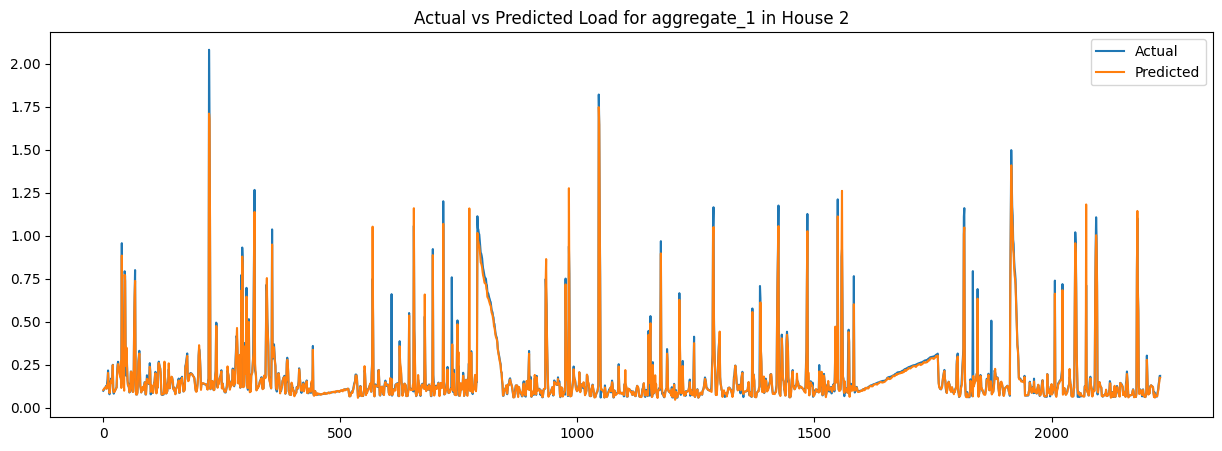

First 5 actual vs predicted values for aggregate_1 in House 2:
Actual: 0.098, Predicted: 0.10273265838623047
Actual: 0.1035, Predicted: 0.10742475837469101
Actual: 0.10533333333333333, Predicted: 0.10898741334676743
Actual: 0.11266666666666665, Predicted: 0.11473741382360458
Actual: 0.11633333333333333, Predicted: 0.11645679175853729
Predicting consumption for washing_machine_12 in House 2...
Epoch 1/20
140/140 [==============================] - 25s 70ms/step - loss: 0.0840 - val_loss: 0.0821 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0403 - val_loss: 0.0732 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0348 - val_loss: 0.0807 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0419 - val_loss: 0.0693 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0330 - val_loss: 0.0696 - lr: 0.0010
Epoch 6/20
140/140 [=============

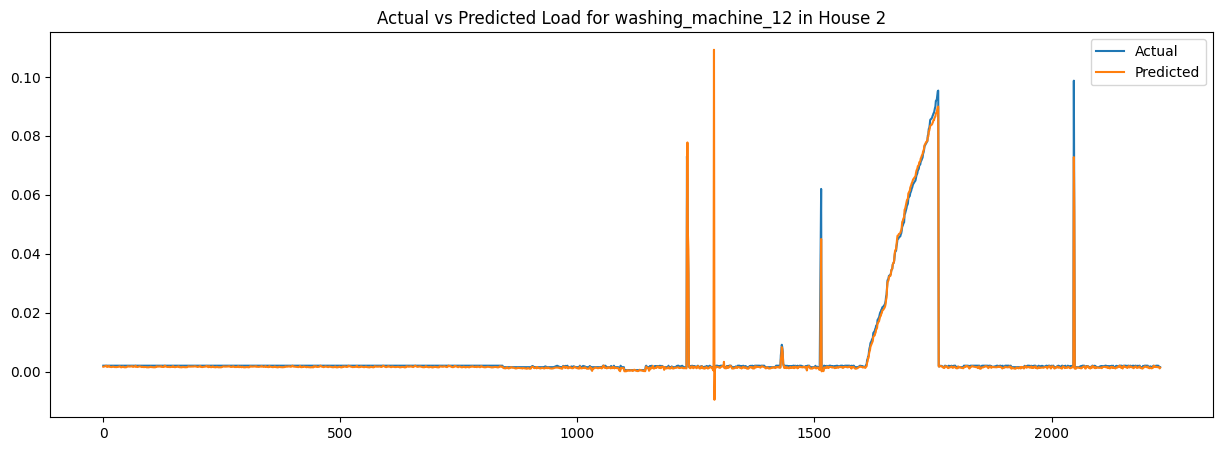

First 5 actual vs predicted values for washing_machine_12 in House 2:
Actual: 0.002, Predicted: 0.001643249997869134
Actual: 0.002, Predicted: 0.00168107938952744
Actual: 0.002, Predicted: 0.0016978567000478506
Actual: 0.002, Predicted: 0.0017650413792580366
Actual: 0.002, Predicted: 0.0018103285692632198
Predicting consumption for monitor_3 in House 2...
Epoch 1/20
140/140 [==============================] - 25s 69ms/step - loss: 0.1175 - val_loss: 0.0363 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0544 - val_loss: 0.0325 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0454 - val_loss: 0.0314 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0426 - val_loss: 0.0218 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0390 - val_loss: 0.0215 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 6s 45ms/step - lo

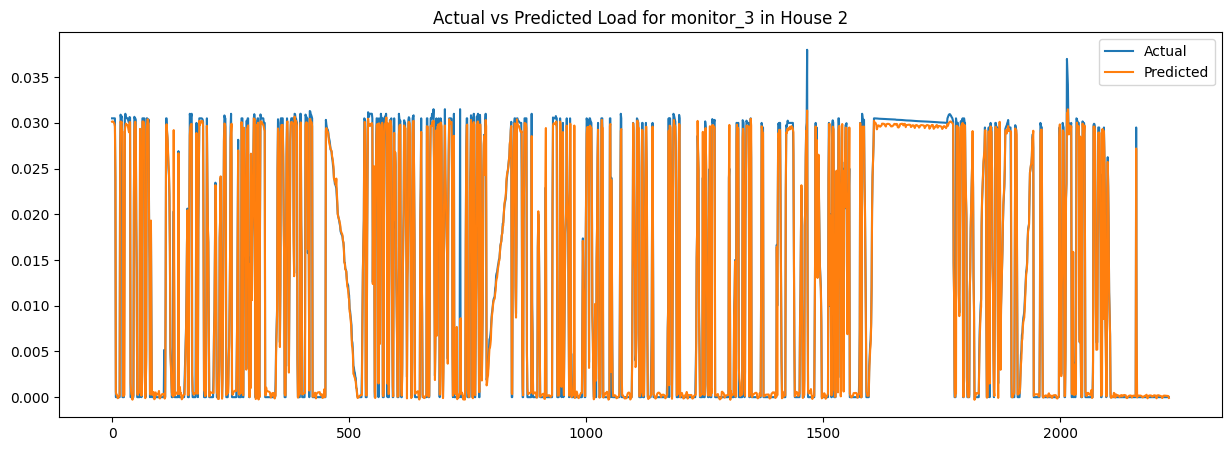

First 5 actual vs predicted values for monitor_3 in House 2:
Actual: 0.0305, Predicted: 0.03013981133699417
Actual: 0.0305, Predicted: 0.03016003407537937
Actual: 0.0305, Predicted: 0.030152609571814537
Actual: 0.0305, Predicted: 0.03008749894797802
Actual: 0.0305, Predicted: 0.030012447386980057
Predicting consumption for fridge_14 in House 2...
Epoch 1/20
140/140 [==============================] - 25s 70ms/step - loss: 0.1807 - val_loss: 0.0866 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 7s 47ms/step - loss: 0.1214 - val_loss: 0.0729 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 6s 45ms/step - loss: 0.1108 - val_loss: 0.0646 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 6s 46ms/step - loss: 0.0988 - val_loss: 0.0697 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 6s 45ms/step - loss: 0.0895 - val_loss: 0.0546 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 7s 46ms/step - loss: 0.084

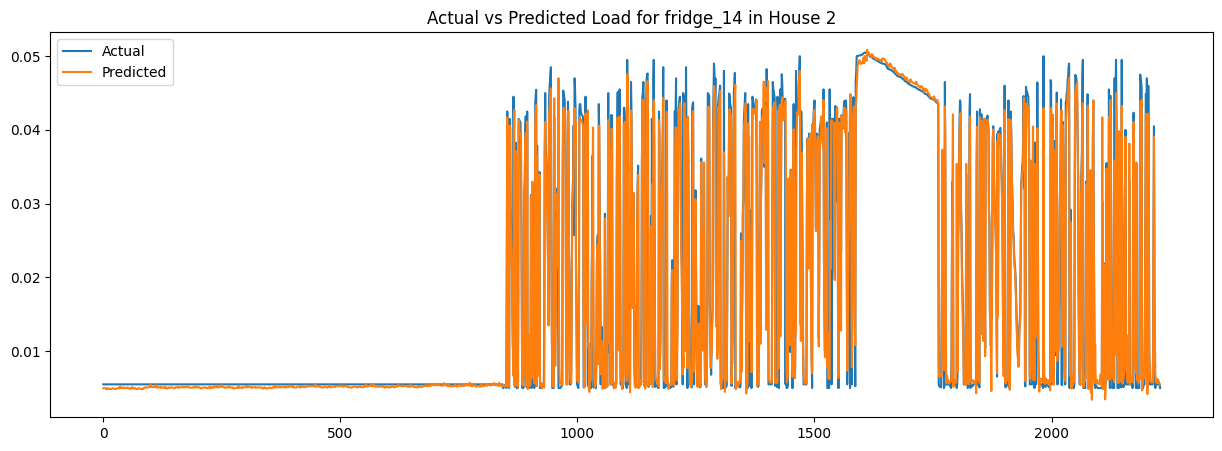

First 5 actual vs predicted values for fridge_14 in House 2:
Actual: 0.0055, Predicted: 0.004968448542058468
Actual: 0.0055, Predicted: 0.004985266365110874
Actual: 0.0055, Predicted: 0.004987161606550217
Actual: 0.0055, Predicted: 0.0049814097583293915
Actual: 0.0055, Predicted: 0.00496049877256155
Predicting consumption for microwave_15 in House 2...
Epoch 1/20
140/140 [==============================] - 25s 70ms/step - loss: 0.4554 - val_loss: 0.2027 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 6s 45ms/step - loss: 0.2015 - val_loss: 0.1314 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 6s 46ms/step - loss: 0.1596 - val_loss: 0.1145 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 6s 45ms/step - loss: 0.1303 - val_loss: 0.1192 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 6s 46ms/step - loss: 0.1209 - val_loss: 0.1318 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 6s 46ms/step - loss:

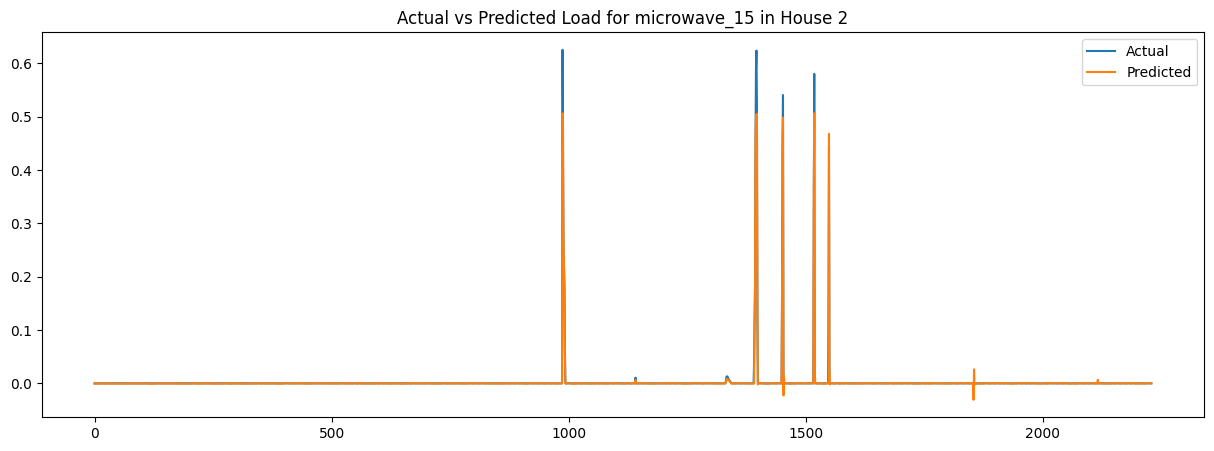

First 5 actual vs predicted values for microwave_15 in House 2:
Actual: 0.0, Predicted: -0.0005894886562600732
Actual: 0.0, Predicted: -0.0005915231304243207
Actual: 0.0, Predicted: -0.0005917142843827605
Actual: 0.0, Predicted: -0.0006106073269620538
Actual: 0.0, Predicted: -0.0006233419990167022
Predicting consumption for kettle_8 in House 2...
Epoch 1/20
140/140 [==============================] - 25s 70ms/step - loss: 0.3876 - val_loss: 0.0796 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 6s 46ms/step - loss: 0.1813 - val_loss: 0.0615 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 6s 46ms/step - loss: 0.1650 - val_loss: 0.0971 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 6s 45ms/step - loss: 0.1747 - val_loss: 0.0380 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 6s 46ms/step - loss: 0.1578 - val_loss: 0.0479 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 6s 45ms/step - loss: 0.162

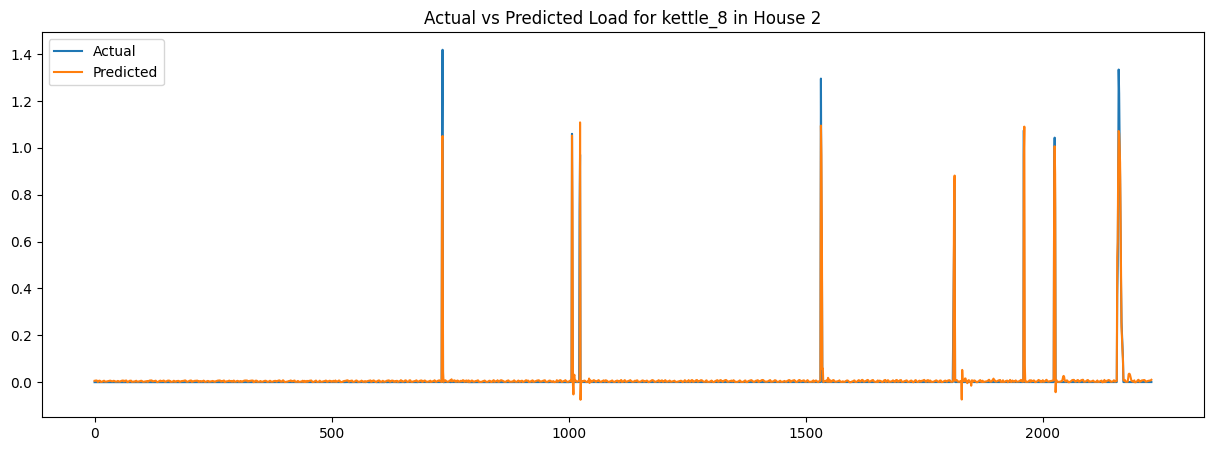

First 5 actual vs predicted values for kettle_8 in House 2:
Actual: 0.0, Predicted: 0.00584983779117465
Actual: 0.0, Predicted: 0.006326351314783096
Actual: 0.0, Predicted: 0.006491864565759897
Actual: 0.0, Predicted: 0.007060251198709011
Actual: 0.0, Predicted: 0.007085255812853575


In [ ]:
# Specify the target house
target_house = 2  # Change this to the desired house number

# Train and evaluate for the target house
house_data = df[target_house]
appliances = key_appliances_per_house[target_house]

results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for appliance in appliances:
    if appliance in house_data.columns:
        print(f"Predicting consumption for {appliance} in House {target_house}...")

        # Use the selected appliance's power consumption for forecasting
        df_load = house_data[[appliance]]

        # Preprocess data
        seq_length = 96  # 48 hours in 30-minute intervals
        X, y, context, scaler = preprocess_data(df_load, seq_length)

        cv_mse, cv_mae, cv_r2 = [], [], []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            context_train, context_test = context[train_index], context[test_index]

            # Build and train Bidirectional GRU model with contextual features
            input_seq = Input(shape=(seq_length, X_train.shape[2]))
            input_context = Input(shape=(seq_length, context_train.shape[2]))

            gru_out = Bidirectional(GRU(128, return_sequences=True))(input_seq)
            gru_out = Dropout(0.3)(gru_out)
            gru_out = Bidirectional(GRU(128, return_sequences=True))(gru_out)
            gru_out = Dropout(0.3)(gru_out)
            gru_out = Bidirectional(GRU(128))(gru_out)
            gru_out = Dropout(0.3)(gru_out)

            context_out = Bidirectional(GRU(64, return_sequences=True))(input_context)
            context_out = Dropout(0.3)(context_out)
            context_out = Bidirectional(GRU(64, return_sequences=True))(context_out)
            context_out = Dropout(0.3)(context_out)
            context_out = Bidirectional(GRU(64))(context_out)
            context_out = Dropout(0.3)(context_out)

            combined = Concatenate()([gru_out, context_out])
            output = Dense(1)(combined)

            model = Model(inputs=[input_seq, input_context], outputs=output)
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

            # Callbacks for early stopping and learning rate reduction
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

            model.fit([X_train, context_train], y_train, epochs=20, batch_size=64, validation_data=([X_test, context_test], y_test),
                      callbacks=[early_stopping, reduce_lr], verbose=1)

            # Make predictions
            y_pred = model.predict([X_test, context_test])

            # Inverse transform predictions
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)

            # Evaluation metrics
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            r2 = r2_score(y_test_inv, y_pred_inv)

            cv_mse.append(mse)
            cv_mae.append(mae)
            cv_r2.append(r2)

        print(f'{appliance} - CV MSE: {np.mean(cv_mse)}, CV MAE: {np.mean(cv_mae)}, CV R²: {np.mean(cv_r2)}')

        # Plot actual vs predicted values
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(y_pred_inv, label='Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted Load for {appliance} in House {target_house}')
        plt.show()

        # Print 5 actual vs predicted values
        print(f"First 5 actual vs predicted values for {appliance} in House {target_house}:")
        for i in range(5):
            print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

        # Store results
        results[f'House {target_house} - {appliance}'] = {'cv_mse': np.mean(cv_mse), 'cv_mae': np.mean(cv_mae), 'cv_r2': np.mean(cv_r2)}

### Model Evaluation of GRU with Contextual features

In [ ]:
# Print summary of results
for key, metrics in results.items():
    print(f"{key} - MSE: {metrics['cv_mse']}, MAE: {metrics['cv_mae']}, R²: {metrics['cv_r2']}")

House 2 - aggregate_1 - MSE: 0.003431252760851012, MAE: 0.013175684830015383, R²: 0.9249198789247997
House 2 - washing_machine_12 - MSE: 6.022473329072863e-06, MAE: 0.00032614360988722377, R²: 0.9723473571310643
House 2 - monitor_3 - MSE: 3.5527431477258486e-06, MAE: 0.0006324509910806484, R²: 0.9795011938908408
House 2 - fridge_14 - MSE: 1.6412946343268934e-05, MAE: 0.001477943022448938, R²: 0.9387866686215132
House 2 - microwave_15 - MSE: 0.0001250882446913557, MAE: 0.000905413369651813, R²: 0.9149407864813224
House 2 - kettle_8 - MSE: 0.0007968227029566905, MAE: 0.003470799647270144, R²: 0.9075748419925773
